## Notebook for training GPR on DC dataset and generating set of suggestions

**Created on 10th August, 2023; modified on 23rd November**

**Dataset: label_ecfp_pca_add_feat_082423.csv**

In [2]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, PandasTools, Fragments, rdMolDescriptors, Descriptors, rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.PandasTools import ChangeMoleculeRendering
from rdkit.Chem.MolStandardize.rdMolStandardize import LargestFragmentChooser
# Silence non-critical RDKit warnings to minimize unnecessary outputs
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
## import train_test_split from sklearn
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, RationalQuadratic, WhiteKernel, Matern, ConstantKernel, DotProduct, PairwiseKernel 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.special import erf
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from IPython.display import SVG, display

import json
from bokeh.plotting import figure, show, output_notebook, ColumnDataSource
from bokeh.models import HoverTool, ColorBar, CategoricalColorMapper
from bokeh.transform import factor_cmap
from bokeh.plotting import figure, output_file, save
from bokeh.transform import linear_cmap
from bokeh.palettes import Turbo256, d3
import pdb
output_notebook()

Loading BokehJS ...

In [1]:
%%bash
pwd
ls -ltr

/Users/riteshk/Library/CloudStorage/Box-Box/Research-postdoc/AL-CE/08-22-23/campaign-3
total 4400
-rw-r--r--  1 riteshk  staff  499365396 Nov 23  2023 unlabel_1mil_ecfp_pca_add_feat_iter_3.csv
-rw-r--r--@ 1 riteshk  staff      15473 Nov 23  2023 just_label_iter_3.csv
-rw-r--r--@ 1 riteshk  staff      44835 Nov 23  2023 label_ecfp_pca_add_feat_iter_2_101123.csv
-rw-r--r--@ 1 riteshk  staff      53765 Nov 23  2023 label_ecfp_pca_add_feat_iter_3_112323.csv
-rw-r--r--  1 riteshk  staff     147657 Nov 23  2023 pairwise_iter3_112323.pkl
-rw-r--r--  1 riteshk  staff     147632 Nov 23  2023 matern_iter3_112323.pkl
-rw-r--r--  1 riteshk  staff     147689 Nov 23  2023 rq_iter3_112323.pkl
-rw-r--r--  1 riteshk  staff     147818 Nov 23  2023 rbfexpsin_iter3_112323.pkl
-rw-r--r--  1 riteshk  staff  800646693 Nov 23  2023 preds_uncer_ei_unlabel_1mil_iter3_112323.csv
-rw-r--r--@ 1 riteshk  staff    2333241 Nov 23  2023 iter_3_top5000_sugg_ei_unique.csv
-rw-r--r--@ 1 riteshk  staff   55339227 Nov 23  

Finding smiles that have been labeled

In [7]:
df_unlabel = pd.read_csv('../campaign-2/unlabel_1mil_ecfp_pca_add_feat_iter_2.csv') ## initial unlabeled data (~1 mil)
df_unlabel.rename(columns={'Unnamed: 0':'index_0'}, inplace=True)
df_unlabel

,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,...,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type
0,0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,-0.373535,0.936724,-0.161937,-0.377185,...,0.258767,0.301779,-0.272648,73.052764,186.939685,1.0,0.0,150,50,2
1,1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,0.728341,0.681048,-1.181697,0.018457,...,0.258767,0.301779,-0.272648,114.079313,186.939685,1.0,0.0,150,50,2
2,2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,-0.342583,1.301206,-0.264839,-0.516489,...,0.258767,0.301779,-0.272648,116.094963,186.939685,1.0,0.0,150,50,2
3,3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,-0.113769,0.728616,-0.486733,-0.311699,...,0.258767,0.301779,-0.272648,70.058995,186.939685,1.0,0.0,150,50,2
4,4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,-0.547668,0.955202,-0.313588,-0.356929,...,0.258767,0.301779,-0.272648,72.044939,186.939685,1.0,0.0,150,50,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999956,999994,CC1ON(C)C(C)C1S(C)(=O)=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.771012,-1.078565,0.565077,0.216605,0.613562,-0.742397,-0.257837,...,0.008496,0.161338,0.109063,193.077264,144.001775,1.0,0.0,150,50,2
999957,999995,COC(=O)C1(N2CCCN(C)C2=O)CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.881747,0.625623,1.808971,0.306581,0.123581,-0.469934,-0.451538,...,0.008496,0.161338,0.109063,240.147392,144.001775,1.0,0.0,150,50,2
999958,999996,COC(=O)N1CCC(OS(C)(=O)=O)CC1=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.700964,0.588889,1.459777,0.806459,-0.042994,-0.081386,0.196396,...,0.008496,0.161338,0.109063,251.046358,144.001775,1.0,0.0,150,50,2
999959,999997,CN(C)C(=O)CN(C)C(=O)C1CCCC1(F)F,[Li+].O=C1O[B-](F)(F)OC1=O,0.558235,0.889818,-0.240008,-0.734436,0.749283,0.799906,-0.856418,...,0.008496,0.161338,0.109063,248.133634,144.001775,1.0,0.0,150,50,2


In [35]:
def get_row(ind):
    sm = df_unlabel.loc[df_unlabel['index_0'] == ind]['solv_comb_sm']
    return df_unlabel.loc[df_unlabel['solv_comb_sm'] == sm.values[0]]

In [37]:
row_1 = get_row(64218)
row_1

,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,...,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type
64213,64218,COC(OC)C(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.763499,-1.479645,0.935298,-0.813958,0.157691,-0.72405,0.577195,...,0.258767,0.301779,-0.272648,144.039814,186.939685,1.0,0.0,150,50,2
380268,380287,COC(OC)C(F)(F)F,[Li+].F[P-](F)(F)(F)(F)F,-0.763499,-1.479645,0.935298,-0.813958,0.157691,-0.72405,0.577195,...,0.195230,0.319099,-0.209425,144.039814,151.980186,1.0,0.0,150,50,2
732778,732810,COC(OC)C(F)(F)F,[Li+].O=C1O[B-](F)(F)OC1=O,-0.763499,-1.479645,0.935298,-0.813958,0.157691,-0.72405,0.577195,...,0.008496,0.161338,0.109063,144.039814,144.001775,1.0,0.0,150,50,2


In [38]:
## Finding labaled data from 2nd campaign
label_iter_3 = pd.DataFrame(columns=df_unlabel.columns)
## the code below will only extract one solvent entry; but we want all three solvent entries
# row_1 = df_unlabel.loc[df_unlabel['index_0'] == 64218] ## CAS: 42415-20-3
# row_2 = df_unlabel.loc[df_unlabel['index_0'] == 68919] ## CAS: 60598-17-6
# row_3 = df_unlabel.loc[df_unlabel['index_0'] == 181511] ## CAS: 116586-94-8
# row_4 = df_unlabel.loc[df_unlabel['index_0'] == 299578] ## CAS: 6607-66-5
# row_5 = df_unlabel.loc[df_unlabel['index_0'] == 27919] ## CAS: 7778-85-0
# row_6 = df_unlabel.loc[df_unlabel['index_0'] == 47980] ## CAS: 109134-39-6
# row_7 = df_unlabel.loc[df_unlabel['index_0'] == 220171] ## CAS: 130156-55-7
# row_8 = df_unlabel.loc[df_unlabel['index_0'] == 78199] ## CAS: 97-97-2
# row_9 = df_unlabel.loc[df_unlabel['index_0'] == 132370] ## CAS: 425-87-6
# row_10 = df_unlabel.loc[df_unlabel['index_0'] == 157735] ## CAS: 10138-89-3
# row_11 = df_unlabel.loc[df_unlabel['index_0'] == 6664] ## CAS: 557-17-5
row_1 = get_row(64218) ## CAS: 42415-20-3
row_2 = get_row(68919) ## CAS: 60598-17-6
row_3 = get_row(181511) ## CAS: 116586-94-8
row_4 = get_row(299578) ## CAS: 6607-66-5
row_5 = get_row(27919) ## CAS: 7778-85-0
row_6 = get_row(47980) ## CAS: 109134-39-6
row_7 = get_row(220171) ## CAS: 130156-55-7
row_8 = get_row(78199) ## CAS: 97-97-2
row_9 = get_row(132370) ## CAS: 425-87-6
row_10 = get_row(157735) ## CAS: 10138-89-3
row_11 = get_row(6664) ## CAS: 557-17-5
label_iter_3 = pd.concat([label_iter_3, row_1, row_2, row_3, row_4, row_5, row_6, row_7, row_8, row_9, row_10, row_11], axis=0)
label_iter_3
# row_11

,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,...,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type
64213,64218,COC(OC)C(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.763499,-1.479645,0.935298,-0.813958,0.157691,-0.724050,0.577195,...,0.258767,0.301779,-0.272648,144.039814,186.939685,1.0,0.0,150,50,2
380268,380287,COC(OC)C(F)(F)F,[Li+].F[P-](F)(F)(F)(F)F,-0.763499,-1.479645,0.935298,-0.813958,0.157691,-0.724050,0.577195,...,0.195230,0.319099,-0.209425,144.039814,151.980186,1.0,0.0,150,50,2
732778,732810,COC(OC)C(F)(F)F,[Li+].O=C1O[B-](F)(F)OC1=O,-0.763499,-1.479645,0.935298,-0.813958,0.157691,-0.724050,0.577195,...,0.008496,0.161338,0.109063,144.039814,144.001775,1.0,0.0,150,50,2
68913,68919,COCC(F)(F)C(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.900533,-1.482508,0.838779,-0.836133,0.037687,-0.440202,0.923087,...,0.258767,0.301779,-0.272648,146.035478,186.939685,1.0,0.0,150,50,2
377054,377072,COCC(F)(F)C(F)F,[Li+].F[P-](F)(F)(F)(F)F,-0.900533,-1.482508,0.838779,-0.836133,0.037687,-0.440202,0.923087,...,0.195230,0.319099,-0.209425,146.035478,151.980186,1.0,0.0,150,50,2
709940,709971,COCC(F)(F)C(F)F,[Li+].O=C1O[B-](F)(F)OC1=O,-0.900533,-1.482508,0.838779,-0.836133,0.037687,-0.440202,0.923087,...,0.008496,0.161338,0.109063,146.035478,144.001775,1.0,0.0,150,50,2
181500,181511,COC(CC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.874616,-1.416077,0.733660,-0.734611,0.144525,-0.589251,0.707575,...,0.258767,0.301779,-0.272648,158.055464,186.939685,1.0,0.0,150,50,2
521472,521496,COC(CC(F)(F)F)OC,[Li+].F[P-](F)(F)(F)(F)F,-0.874616,-1.416077,0.733660,-0.734611,0.144525,-0.589251,0.707575,...,0.195230,0.319099,-0.209425,158.055464,151.980186,1.0,0.0,150,50,2
905423,905461,COC(CC(F)(F)F)OC,[Li+].O=C1O[B-](F)(F)OC1=O,-0.874616,-1.416077,0.733660,-0.734611,0.144525,-0.589251,0.707575,...,0.008496,0.161338,0.109063,158.055464,144.001775,1.0,0.0,150,50,2
299564,299578,COCCC(C)(OC)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.898381,-1.467829,1.086570,-0.709556,0.226229,0.227359,1.573875,...,0.258767,0.301779,-0.272648,148.109944,186.939685,1.0,0.0,150,50,2


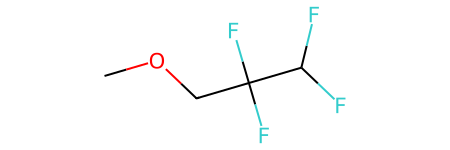

In [137]:
Chem.MolFromSmiles('COC(CC(F)(F)F)OC')
# Chem.MolFromSmiles('COCCC(C)(OC)OC')
# Chem.MolFromSmiles('COCC(C)OC')
# Chem.MolFromSmiles('CO[Si](CCC(F)(F)C(F)(F)C(F)(F)F)(OC)OC')
Chem.MolFromSmiles('COCCOCOCC(F)(F)F')
# Chem.MolFromSmiles('COC(CCl)OC')
# Chem.MolFromSmiles('COC(F)(F)C(F)Cl')
# Chem.MolFromSmiles('COC(C)CC(OC)OC')
# Chem.MolFromSmiles('CCCOC')
Chem.MolFromSmiles('COC(OC)C(F)(F)F')
Chem.MolFromSmiles('COCC(F)(F)C(F)F')

In [33]:
label_iter_3['solv_comb_sm'].unique()

array(['COC(OC)C(F)(F)F', 'COCC(F)(F)C(F)F', 'COC(CC(F)(F)F)OC',
       'COCCC(C)(OC)OC', 'COCC(C)OC',
       'CO[Si](CCC(F)(F)C(F)(F)C(F)(F)F)(OC)OC', 'COCCOCOCC(F)(F)F',
       'COC(CCl)OC', 'COC(F)(F)C(F)Cl', 'COC(C)CC(OC)OC', 'CCCOC'],
      dtype=object)

In [39]:
df_unlabel_ = df_unlabel.drop(label_iter_3.index) ## drop the labeled molecules from the unlabeled data
df_unlabel_

,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,...,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type
0,0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,-0.373535,0.936724,-0.161937,-0.377185,...,0.258767,0.301779,-0.272648,73.052764,186.939685,1.0,0.0,150,50,2
1,1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,0.728341,0.681048,-1.181697,0.018457,...,0.258767,0.301779,-0.272648,114.079313,186.939685,1.0,0.0,150,50,2
2,2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,-0.342583,1.301206,-0.264839,-0.516489,...,0.258767,0.301779,-0.272648,116.094963,186.939685,1.0,0.0,150,50,2
3,3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,-0.113769,0.728616,-0.486733,-0.311699,...,0.258767,0.301779,-0.272648,70.058995,186.939685,1.0,0.0,150,50,2
4,4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,-0.547668,0.955202,-0.313588,-0.356929,...,0.258767,0.301779,-0.272648,72.044939,186.939685,1.0,0.0,150,50,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999956,999994,CC1ON(C)C(C)C1S(C)(=O)=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.771012,-1.078565,0.565077,0.216605,0.613562,-0.742397,-0.257837,...,0.008496,0.161338,0.109063,193.077264,144.001775,1.0,0.0,150,50,2
999957,999995,COC(=O)C1(N2CCCN(C)C2=O)CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.881747,0.625623,1.808971,0.306581,0.123581,-0.469934,-0.451538,...,0.008496,0.161338,0.109063,240.147392,144.001775,1.0,0.0,150,50,2
999958,999996,COC(=O)N1CCC(OS(C)(=O)=O)CC1=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.700964,0.588889,1.459777,0.806459,-0.042994,-0.081386,0.196396,...,0.008496,0.161338,0.109063,251.046358,144.001775,1.0,0.0,150,50,2
999959,999997,CN(C)C(=O)CN(C)C(=O)C1CCCC1(F)F,[Li+].O=C1O[B-](F)(F)OC1=O,0.558235,0.889818,-0.240008,-0.734436,0.749283,0.799906,-0.856418,...,0.008496,0.161338,0.109063,248.133634,144.001775,1.0,0.0,150,50,2


In [40]:
df_unlabel_.to_csv('unlabel_1mil_ecfp_pca_add_feat_iter_3.csv') ## save the unlabeled data for the next iteration
# df_unlabel_ = pd.read_csv('unlabel_1mil_ecfp_pca_add_feat_iter_3.csv') ## read the unlabeled data for the next iteration
# df_unlabel_

In [41]:
label_iter_3.to_csv('just_label_iter_3.csv', index=False) ## also save the labeled data from the 1st iteration of suggestions
# label_iter_3 = pd.read_csv('just_label_iter_3.csv') ## read the labeled data labeled data from the 1st iteration of suggestions
# label_iter_3

In [42]:
df = pd.read_csv('label_ecfp_pca_add_feat_iter_3_112323.csv') ## added the labeled data from the 2nd iteration of suggestions to the initial labeled data manually
df

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,norm_capacity_14,norm_capacity_15,norm_capacity_16,norm_capacity_17,norm_capacity_18,norm_capacity_19,norm_capacity_20,norm_capacity_21,norm_capacity_22,norm_capacity_23
0,COCCOC,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.845301,-0.995151,1.062720,-0.357552,-0.308720,0.309456,0.693325,0.613072,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
1,COCCOC(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.183255,-0.948338,0.615257,-0.582269,-1.010187,-0.522075,0.496896,0.301582,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
2,COCCOCC(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.240814,-0.970769,0.671105,-0.607789,-1.124651,-0.436617,0.628824,0.421934,...,0.022233,0.02168,0.022967,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
3,COCCOCC(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.240814,-0.970769,0.671105,-0.607789,-1.124651,-0.436617,0.628824,0.421934,...,0.000573,0.00046,0.000360,0.000407,0.0006,0.000593,0.000447,0.000333,0.0,0.0
4,CCOCCOC(C)(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.879184,-1.539457,0.507075,-0.111830,0.800175,0.133053,0.926130,-0.208395,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,COC(F)(F)C(F)Cl,[Li+].O=C1O[B-](F)(F)OC1=O,-0.743406,-1.487900,0.912048,-0.821155,0.293529,-0.651772,0.598413,-0.220786,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
117,COC(C)CC(OC)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.908123,-1.333408,0.482503,-0.688418,-0.753605,-0.895700,0.057641,0.022552,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
118,COC(C)CC(OC)OC,[Li+].F[P-](F)(F)(F)(F)F,-0.908123,-1.333408,0.482503,-0.688418,-0.753605,-0.895700,0.057641,0.022552,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
119,COC(C)CC(OC)OC,[Li+].O=C1O[B-](F)(F)OC1=O,-0.908123,-1.333408,0.482503,-0.688418,-0.753605,-0.895700,0.057641,0.022552,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0


In [43]:
df['theor_capacity'].unique()

array([150, 203, 161])

In [44]:
## Important change: on 24th August, 2023
df_ = df.copy()
df_.drop(['conc_salt_2', 'pressure_type'], axis=1, inplace=True) ## dropping 'conc_salt_2' and 'pressure_type' columns as I think may not be that important
df_

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,norm_capacity_14,norm_capacity_15,norm_capacity_16,norm_capacity_17,norm_capacity_18,norm_capacity_19,norm_capacity_20,norm_capacity_21,norm_capacity_22,norm_capacity_23
0,COCCOC,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.845301,-0.995151,1.062720,-0.357552,-0.308720,0.309456,0.693325,0.613072,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
1,COCCOC(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.183255,-0.948338,0.615257,-0.582269,-1.010187,-0.522075,0.496896,0.301582,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
2,COCCOCC(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.240814,-0.970769,0.671105,-0.607789,-1.124651,-0.436617,0.628824,0.421934,...,0.022233,0.02168,0.022967,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
3,COCCOCC(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.240814,-0.970769,0.671105,-0.607789,-1.124651,-0.436617,0.628824,0.421934,...,0.000573,0.00046,0.000360,0.000407,0.0006,0.000593,0.000447,0.000333,0.0,0.0
4,CCOCCOC(C)(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.879184,-1.539457,0.507075,-0.111830,0.800175,0.133053,0.926130,-0.208395,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,COC(F)(F)C(F)Cl,[Li+].O=C1O[B-](F)(F)OC1=O,-0.743406,-1.487900,0.912048,-0.821155,0.293529,-0.651772,0.598413,-0.220786,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
117,COC(C)CC(OC)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.908123,-1.333408,0.482503,-0.688418,-0.753605,-0.895700,0.057641,0.022552,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
118,COC(C)CC(OC)OC,[Li+].F[P-](F)(F)(F)(F)F,-0.908123,-1.333408,0.482503,-0.688418,-0.753605,-0.895700,0.057641,0.022552,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
119,COC(C)CC(OC)OC,[Li+].O=C1O[B-](F)(F)OC1=O,-0.908123,-1.333408,0.482503,-0.688418,-0.753605,-0.895700,0.057641,0.022552,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0


In [45]:
X = df_.iloc[:,2:27]
y = df_['norm_capacity_3']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) ## will be using complete dataset for training
X_test

,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,solv_ecfp_pca_8,solv_ecfp_pca_9,...,salt_ecfp_pca_5,salt_ecfp_pca_6,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,theor_capacity,amt_electrolyte
44,-0.754341,-1.566146,0.391263,0.131682,0.129455,0.247713,0.142633,0.199871,-0.508919,-0.370374,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,118.099380,186.939685,1.0,150,50
47,-1.183255,-0.948338,0.615257,-0.582269,-1.010187,-0.522075,0.496896,0.301582,-0.507040,-0.352331,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,118.099380,186.939685,2.0,150,50
4,-0.879184,-1.539457,0.507075,-0.111830,0.800175,0.133053,0.926130,-0.208395,0.099267,-0.130341,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,146.130680,186.939685,2.2,150,50
55,-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,-0.615222,-0.539429,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,111.999429,186.939685,2.0,150,50
26,-0.843804,-0.934786,1.100089,-0.357726,-0.344566,0.308553,0.688237,0.572082,-0.786094,-0.396651,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,236.143119,186.939685,1.0,150,50
64,0.876502,-1.072168,-0.081963,0.736596,0.206000,-0.486059,0.263508,0.370727,0.175131,-0.596035,...,0.203690,-0.160053,0.195230,0.319099,-0.209425,99.104799,151.980186,1.0,150,50
73,0.771488,-1.039048,0.946017,-0.178269,0.757423,-0.206798,-1.220774,0.577555,-0.129238,-1.193203,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,166.099380,186.939685,1.0,150,50
10,-0.899245,-1.039674,1.079794,-0.351354,-0.360827,0.421555,0.804488,0.673995,-0.878265,-0.450959,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,134.094294,186.939685,1.0,150,50
40,-1.190545,-1.129056,1.030187,-0.668465,-0.151808,-0.097468,1.281233,0.277076,-0.442167,-0.403692,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,190.061692,186.939685,1.0,203,50
108,-1.094894,-1.404056,0.585391,-0.764865,-1.127708,-0.580104,0.501909,0.331475,-0.412698,-0.318497,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,104.083730,144.001775,1.0,150,50


In [46]:
std_scale_ = StandardScaler().fit(X)
X_std = std_scale_.transform(X)
X_std = pd.DataFrame(X_std, columns=X.columns)

In [47]:
kernel_1 = PairwiseKernel(metric='polynomial') + WhiteKernel(noise_level=0.1)
kernel_3 = RBF(length_scale=0.01) + WhiteKernel(noise_level=0.1)
kernel_2 = Matern(length_scale=0.01, nu=2.5) + WhiteKernel(noise_level=0.1)
kernel_4 = Matern(length_scale=0.01, nu=1.5) + WhiteKernel(noise_level=0.1)
kernel_5 = ExpSineSquared(length_scale=0.01, periodicity=1.0) + WhiteKernel(noise_level=0.1)
kernel_6 = RationalQuadratic(length_scale=0.01, alpha=1.0) + WhiteKernel(noise_level=0.1)
kernel_7 = DotProduct(sigma_0=0.1) + WhiteKernel(noise_level=0.1)
kernel_8 = RBF(length_scale=0.01) + ExpSineSquared(length_scale=0.01, periodicity=1.0) + WhiteKernel(noise_level=0.1)
kernels = [kernel_1, kernel_2, kernel_3, kernel_4, kernel_5, kernel_6, kernel_7, kernel_8]
kernel_name = ['PairwiseKernel', 'Matern 5/2', 'RBF', 'Matern 3/2', 'ExpSineSquared', 'RationalQuadratic', 'DotProduct', 'RBF+ExpSineSquared']
cv_dict = {'kernel': list(), 'score': list()}

In [48]:
# def negative_log_likelihood(noise_level, length_scale, alpha, kernel_name):
# def negative_log_likelihood(params, kernel_name):
def negative_log_likelihood_rbf(params):
    noise_level, length_scale, alpha = params ## for adding regularization parameter
    # noise_level, length_scale = params ## in case of not adding regularization parameter
    # if kernel_name == 'RBF':
    kernel = RBF(length_scale=length_scale)
    # elif kernel_name == 'Matern-5/2':
        # kernel = Matern(length_scale=length_scale, nu=2.5)
    # elif kernel_name == 'Pairwise':
        # kernel = PairwiseKernel(metric='polynomial')
    white_kernel = WhiteKernel(noise_level=noise_level)
    composite_kernel = kernel + white_kernel
    gpr = GaussianProcessRegressor(kernel=composite_kernel, alpha=alpha, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42) ## for adding regularization parameter
    # gpr = GaussianProcessRegressor(kernel=composite_kernel, alpha=0.0, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=0) ## in case of not adding regularization parameter
    gpr.fit(X_std, y)
    pred_mean, pred_std = gpr.predict(X_std, return_std=True)
    log_likelihood = np.sum(norm.logpdf(y, loc=pred_mean, scale=pred_std))
    return -log_likelihood

def negative_log_likelihood_rq(params):
    noise_level, length_scale, alpha_k, alpha = params ## for adding regularization parameter
    kernel = RationalQuadratic(length_scale=length_scale, alpha=alpha_k)
    white_kernel = WhiteKernel(noise_level=noise_level)
    composite_kernel = kernel + white_kernel
    gpr = GaussianProcessRegressor(kernel=composite_kernel, alpha=alpha, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42) ## for adding regularization parameter
    gpr.fit(X_std, y)
    pred_mean, pred_std = gpr.predict(X_std, return_std=True)
    log_likelihood = np.sum(norm.logpdf(y, loc=pred_mean, scale=pred_std))
    return -log_likelihood

def negative_log_likelihood_rbf_expsin(params):
    noise_level, length_scale, periodicity, alpha = params ## for adding regularization parameter
    kernel = RBF(length_scale=length_scale) + ExpSineSquared(length_scale=length_scale, periodicity=periodicity)
    white_kernel = WhiteKernel(noise_level=noise_level)
    composite_kernel = kernel + white_kernel
    gpr = GaussianProcessRegressor(kernel=composite_kernel, alpha=alpha, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42) ## for adding regularization parameter
    gpr.fit(X_std, y)
    pred_mean, pred_std = gpr.predict(X_std, return_std=True)
    log_likelihood = np.sum(norm.logpdf(y, loc=pred_mean, scale=pred_std))
    return -log_likelihood

def negative_log_likelihood_matern(params):
    noise_level, length_scale, alpha = params
    kernel = Matern(length_scale=length_scale, nu=1.5)
    white_kernel = WhiteKernel(noise_level=noise_level)
    composite_kernel = kernel + white_kernel
    gpr = GaussianProcessRegressor(kernel=composite_kernel, alpha=alpha, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42)
    gpr.fit(X_std, y)
    pred_mean, pred_std = gpr.predict(X_std, return_std=True)
    log_likelihood = np.sum(norm.logpdf(y, loc=pred_mean, scale=pred_std))
    return -log_likelihood

def negative_log_likelihood_pairwise(params):
    noise_level, length_scale, alpha = params
    kernel = PairwiseKernel(metric="polynomial")
    white_kernel = WhiteKernel(noise_level=noise_level)
    composite_kernel = kernel + white_kernel
    gpr = GaussianProcessRegressor(kernel=composite_kernel, alpha=alpha, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42)
    gpr.fit(X_std, y)
    pred_mean, pred_std = gpr.predict(X_std, return_std=True)
    log_likelihood = np.sum(norm.logpdf(y, loc=pred_mean, scale=pred_std))
    return -log_likelihood

**Optimize Pairwise kernel**

In [49]:
initial_guess = [0.15, 0.01, 0.02] # initial guess for noise_level, length_scale, alpha
param_bounds = [(1e-4, 1.0), (1e-5, 50.0), (1e-4, 0.1)] # bounds for noise_level, length_scale, alpha
result = minimize(negative_log_likelihood_pairwise, initial_guess, bounds=param_bounds)
optimized_hyperparameters = result.x
optimized_noise_level, optimized_length_scale, optimized_alpha = optimized_hyperparameters
print("Optimized noise_level:", optimized_noise_level)
print("Optimized length_scale:", optimized_length_scale)
print("Optimized alpha:", optimized_alpha)

/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of i

Optimized noise_level: 0.15
Optimized length_scale: 0.01
Optimized alpha: 0.0075110196045018625


In [50]:
optimized_kernel = PairwiseKernel(metric="polynomial") + WhiteKernel(noise_level=optimized_noise_level)
gpr_optimized = GaussianProcessRegressor(kernel=optimized_kernel, alpha=optimized_alpha, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42)
gpr_optimized.fit(X_std, y)
y_pred, y_uncer = gpr_optimized.predict(X_std, return_std=True)
print("R2 score:", r2_score(y, y_pred))
print("MAE:", mean_absolute_error(y, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred)))

R2 score: 0.5570196484583915
MAE: 0.15637294140203956
RMSE: 0.19978935488714775


In [51]:
gpr_optimized.get_params()
gpr_optimized.log_marginal_likelihood(gpr_optimized.kernel_.theta)
gpr_optimized.kernel_

PairwiseKernel(gamma=0.000572629838532073, metric=polynomial) + WhiteKernel(noise_level=0.0375)

In [52]:
pred_df = pd.DataFrame({'y': y, 'y_pred': y_pred, 'y_uncer': y_uncer})
pred_df

,y,y_pred,y_uncer
0,0.276580,0.362499,0.201281
1,0.661460,0.294147,0.201302
2,0.178387,0.336219,0.202146
3,0.216953,0.336219,0.202146
4,0.026187,0.474752,0.208619
...,...,...,...
116,0.000000,0.059785,0.206152
117,0.000600,0.189542,0.202242
118,0.000600,0.055544,0.205964
119,0.000600,0.029926,0.207177


**Optimize RationalQuadratic kernel**

In [53]:
initial_guess = [0.15, 0.01, 0.01, 0.02] # initial guess for noise_level, length_scale, alpha_k, alpha
param_bounds = [(1e-4, 1.0), (1e-5, 50.0), (1e-5, 50.0), (1e-4, 0.1)] # bounds for noise_level, length_scale, alpha_k, alpha
result = minimize(negative_log_likelihood_rq, initial_guess, bounds=param_bounds)
optimized_hyperparameters = result.x
optimized_noise_level, optimized_length_scale, optimized_alpha_k, optimized_alpha = optimized_hyperparameters
print("Optimized noise_level:", optimized_noise_level)
print("Optimized length_scale:", optimized_length_scale)
print("Optimized alpha_k:", optimized_alpha_k)
print("Optimized alpha:", optimized_alpha)

/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warning

Optimized noise_level: 0.15
Optimized length_scale: 0.010793271126051407
Optimized alpha_k: 0.01
Optimized alpha: 0.015201476444750707


In [54]:
optimized_kernel = RationalQuadratic(length_scale=optimized_length_scale, alpha=optimized_alpha_k) + WhiteKernel(noise_level=optimized_noise_level)
gpr_optimized = GaussianProcessRegressor(kernel=optimized_kernel, alpha=optimized_alpha, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42)
gpr_optimized.fit(X_std, y)
y_pred, y_uncer = gpr_optimized.predict(X_std, return_std=True)
print("R2 score:", r2_score(y, y_pred))
print("MAE:", mean_absolute_error(y, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred)))

R2 score: 0.9069742355679667
MAE: 0.05894396157484913
RMSE: 0.09155493035063686


In [55]:
gpr_optimized.get_params()
gpr_optimized.log_marginal_likelihood(gpr_optimized.kernel_.theta)
gpr_optimized.kernel_

RationalQuadratic(alpha=0.00971, length_scale=3.64) + WhiteKernel(noise_level=0.00328)

In [56]:
pred_df = pd.DataFrame({'y': y, 'y_pred': y_pred, 'y_uncer': y_uncer})
pred_df

,y,y_pred,y_uncer
0,0.276580,0.309692,0.101042
1,0.661460,0.438722,0.113171
2,0.178387,0.267062,0.099599
3,0.216953,0.267062,0.099599
4,0.026187,0.149524,0.126456
...,...,...,...
116,0.000000,0.007193,0.110020
117,0.000600,0.076225,0.122177
118,0.000600,0.015195,0.123502
119,0.000600,0.009368,0.123718


**Optimize Matern-3/2 kernel**

In [57]:
initial_guess = [0.15, 0.01, 0.02] # initial guess for noise_level, length_scale, alpha
param_bounds = [(1e-4, 1.0), (1e-5, 50.0), (1e-4, 0.1)] # bounds for noise_level, length_scale, alpha
result = minimize(negative_log_likelihood_matern, initial_guess, bounds=param_bounds)
optimized_hyperparameters = result.x
optimized_noise_level, optimized_length_scale, optimized_alpha = optimized_hyperparameters
print("Optimized noise_level:", optimized_noise_level)
print("Optimized length_scale:", optimized_length_scale)
print("Optimized alpha:", optimized_alpha)

/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warning

Optimized noise_level: 0.15
Optimized length_scale: 0.01
Optimized alpha: 0.009619614363672724


In [58]:
optimized_kernel = Matern(length_scale=optimized_length_scale, nu=1.5) + WhiteKernel(noise_level=optimized_noise_level)
gpr_optimized = GaussianProcessRegressor(kernel=optimized_kernel, alpha=optimized_alpha, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42)
gpr_optimized.fit(X_std, y)
y_pred, y_uncer = gpr_optimized.predict(X_std, return_std=True)
print("R2 score:", r2_score(y, y_pred))
print("MAE:", mean_absolute_error(y, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred)))

R2 score: 0.6131406929443397
MAE: 0.13650269118055786
RMSE: 0.18670529621239326


In [59]:
gpr_optimized.get_params()
gpr_optimized.log_marginal_likelihood(gpr_optimized.kernel_.theta)
gpr_optimized.kernel_

Matern(length_scale=34.5, nu=1.5) + WhiteKernel(noise_level=0.0318)

In [60]:
pred_df = pd.DataFrame({'y': y, 'y_pred': y_pred, 'y_uncer': y_uncer})
pred_df

,y,y_pred,y_uncer
0,0.276580,0.355771,0.188319
1,0.661460,0.303291,0.188503
2,0.178387,0.339755,0.189583
3,0.216953,0.339755,0.189583
4,0.026187,0.460277,0.199394
...,...,...,...
116,0.000000,0.022082,0.196818
117,0.000600,0.190296,0.190368
118,0.000600,0.023640,0.196265
119,0.000600,-0.001122,0.198542


**Optimize RBF-ExpineSquared kernel**

In [61]:
initial_guess = [0.15, 0.01, 1.0, 0.02] # initial guess for noise_level, length_scale, periodicity, alpha
param_bounds = [(1e-4, 1.0), (1e-5, 50.0), (1e-2, 10.0), (1e-4, 0.1)] # bounds for noise_level, length_scale, periodicity, alpha
result = minimize(negative_log_likelihood_rbf_expsin, initial_guess, bounds=param_bounds)
optimized_hyperparameters = result.x
optimized_noise_level, optimized_length_scale, optimized_periodicity, optimized_alpha = optimized_hyperparameters
print("Optimized noise_level:", optimized_noise_level)
print("Optimized length_scale:", optimized_length_scale)
print("Optimized periodicity:", optimized_periodicity)
print("Optimized alpha:", optimized_alpha)

/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specif

Optimized noise_level: 0.15
Optimized length_scale: 0.01
Optimized periodicity: 1.0
Optimized alpha: 0.020098565775320966


In [62]:
optimized_kernel = RBF(length_scale=optimized_length_scale) + ExpSineSquared(length_scale=optimized_length_scale, periodicity=optimized_periodicity) + WhiteKernel(noise_level=optimized_noise_level)
gpr_optimized = GaussianProcessRegressor(kernel=optimized_kernel, alpha=optimized_alpha, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42)
gpr_optimized.fit(X_std, y)
y_pred, y_uncer = gpr_optimized.predict(X_std, return_std=True)
print("R2 score:", r2_score(y, y_pred))
print("MAE:", mean_absolute_error(y, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred)))

/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


R2 score: 0.6045946834097001
MAE: 0.14248941993214526
RMSE: 0.1887562606124755


In [63]:
gpr_optimized.get_params()
gpr_optimized.log_marginal_likelihood(gpr_optimized.kernel_.theta)
gpr_optimized.kernel_

RBF(length_scale=19.5) + ExpSineSquared(length_scale=44.2, periodicity=7.94) + WhiteKernel(noise_level=0.0244)

In [64]:
pred_df = pd.DataFrame({'y': y, 'y_pred': y_pred, 'y_uncer': y_uncer})
pred_df

,y,y_pred,y_uncer
0,0.276580,0.351997,0.168357
1,0.661460,0.294082,0.168287
2,0.178387,0.332942,0.169512
3,0.216953,0.332942,0.169512
4,0.026187,0.456429,0.180706
...,...,...,...
116,0.000000,0.042661,0.175060
117,0.000600,0.175329,0.170392
118,0.000600,0.033551,0.175809
119,0.000600,0.014505,0.176840


**Production runs**

In [65]:
# df_unlabel = pd.read_csv('unlabel_1mil_ecfp_pca_add_feat.csv')
# df_unlabel_ = df_unlabel.copy()
df_unlabel_.drop(['conc_salt_2', 'pressure_type'], axis=1, inplace=True) ## dropping 'conc_salt_2' and 'pressure_type' columns as I think may not be that important
df_unlabel_

,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,...,salt_ecfp_pca_5,salt_ecfp_pca_6,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,theor_capacity,amt_electrolyte
0,0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,-0.373535,0.936724,-0.161937,-0.377185,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,73.052764,186.939685,1.0,150,50
1,1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,0.728341,0.681048,-1.181697,0.018457,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,114.079313,186.939685,1.0,150,50
2,2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,-0.342583,1.301206,-0.264839,-0.516489,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,116.094963,186.939685,1.0,150,50
3,3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,-0.113769,0.728616,-0.486733,-0.311699,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,70.058995,186.939685,1.0,150,50
4,4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,-0.547668,0.955202,-0.313588,-0.356929,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,72.044939,186.939685,1.0,150,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999956,999994,CC1ON(C)C(C)C1S(C)(=O)=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.771012,-1.078565,0.565077,0.216605,0.613562,-0.742397,-0.257837,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,193.077264,144.001775,1.0,150,50
999957,999995,COC(=O)C1(N2CCCN(C)C2=O)CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.881747,0.625623,1.808971,0.306581,0.123581,-0.469934,-0.451538,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,240.147392,144.001775,1.0,150,50
999958,999996,COC(=O)N1CCC(OS(C)(=O)=O)CC1=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.700964,0.588889,1.459777,0.806459,-0.042994,-0.081386,0.196396,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,251.046358,144.001775,1.0,150,50
999959,999997,CN(C)C(=O)CN(C)C(=O)C1CCCC1(F)F,[Li+].O=C1O[B-](F)(F)OC1=O,0.558235,0.889818,-0.240008,-0.734436,0.749283,0.799906,-0.856418,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,248.133634,144.001775,1.0,150,50


In [66]:
# uniq_smiles = df_unlabel_['smiles'].unique()
df_unlabel_uniq = df_unlabel_.drop_duplicates(subset=['solv_comb_sm'], keep='first')
df_unlabel_uniq

,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,...,salt_ecfp_pca_5,salt_ecfp_pca_6,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,theor_capacity,amt_electrolyte
0,0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,-0.373535,0.936724,-0.161937,-0.377185,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,73.052764,186.939685,1.0,150,50
1,1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,0.728341,0.681048,-1.181697,0.018457,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,114.079313,186.939685,1.0,150,50
2,2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,-0.342583,1.301206,-0.264839,-0.516489,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,116.094963,186.939685,1.0,150,50
3,3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,-0.113769,0.728616,-0.486733,-0.311699,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,70.058995,186.939685,1.0,150,50
4,4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,-0.547668,0.955202,-0.313588,-0.356929,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,72.044939,186.939685,1.0,150,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999946,999984,CCCCN1C(=O)OCC1[SiH](C)C,[Li+].O=C1O[B-](F)(F)OC1=O,0.627609,-0.998588,-0.085111,1.419019,0.429198,0.064939,-0.547796,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,201.118505,144.001775,1.0,150,50
999948,999986,CC(C)(C)C(=O)N1C2CCC1COC2,[Li+].O=C1O[B-](F)(F)OC1=O,0.902927,0.033572,0.856049,-0.034590,1.299159,-0.295645,0.100524,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,197.141579,144.001775,1.0,150,50
999949,999987,CC(C)(C)C(=O)CS(=O)(=O)CC(=O)N1CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.621175,0.407378,0.570353,0.639576,1.375775,-0.858058,0.668906,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,275.119129,144.001775,1.0,150,50
999950,999988,CCO[Si](CCC(C)SC)(OC)OC,[Li+].O=C1O[B-](F)(F)OC1=O,-1.112749,-1.140740,0.140488,-0.169667,-0.945768,-0.802173,-0.102715,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,238.105892,144.001775,1.0,150,50


In [67]:
# df_unlabel_.drop(columns=['Unnamed: 0'], inplace=True)
X_un = df_unlabel_.iloc[:,3:]
X_un_std = std_scale_.transform(X_un)
X_un_std = pd.DataFrame(X_un_std, columns=X_un.columns)
# X_std = std_scale_.transform(X)
# X_std = pd.DataFrame(X_std, columns=X.columns)
X_un_std

,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,solv_ecfp_pca_8,solv_ecfp_pca_9,...,salt_ecfp_pca_5,salt_ecfp_pca_6,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,theor_capacity,amt_electrolyte
0,-0.002670,0.598017,-2.600971,0.127038,1.646590,-0.162162,-0.685668,-0.086628,-1.472073,0.462707,...,0.359436,-0.632032,0.544270,0.381800,-0.500093,-1.828868,0.390199,-0.340606,-0.348976,0.256565
1,1.599178,0.721053,-0.163579,3.009106,1.146176,-2.601102,-0.229753,1.633845,-1.501195,0.418871,...,0.359436,-0.632032,0.544270,0.381800,-0.500093,-0.872325,0.390199,-0.340606,-0.348976,0.256565
2,-0.296968,3.051313,-2.199165,0.207996,2.359964,-0.408269,-0.846194,-0.221817,-1.449184,0.506683,...,0.359436,-0.632032,0.544270,0.381800,-0.500093,-0.825329,0.390199,-0.340606,-0.348976,0.256565
3,0.203525,-0.390509,-0.335000,0.806483,1.239278,-0.938969,-0.610206,-0.434163,-2.029590,0.488273,...,0.359436,-0.632032,0.544270,0.381800,-0.500093,-1.898668,0.390199,-0.340606,-0.348976,0.256565
4,0.047661,0.703627,-2.697777,-0.328424,1.682757,-0.524861,-0.662327,0.040882,-1.552105,0.457402,...,0.359436,-0.632032,0.544270,0.381800,-0.500093,-1.852365,0.390199,-0.340606,-0.348976,0.256565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999925,1.308615,0.206203,-0.500363,1.670608,1.014092,-1.550435,-0.548139,-0.136478,-2.470496,2.000714,...,-2.261459,1.898888,-2.301366,-2.286992,2.324351,0.969530,-1.351246,-0.340606,-0.348976,0.256565
999926,1.441053,4.392222,2.593901,1.905950,0.055088,-0.898792,-0.771348,3.385207,1.784507,-0.866216,...,-2.261459,1.898888,-2.301366,-2.286992,2.324351,2.066980,-1.351246,-0.340606,-0.348976,0.256565
999927,1.224837,4.301991,1.725261,3.213431,-0.270935,0.030491,-0.024706,-1.552038,-0.666412,1.500194,...,-2.261459,1.898888,-2.301366,-2.286992,2.324351,2.321092,-1.351246,-0.340606,-0.348976,0.256565
999928,1.054133,5.041168,-2.503063,-0.816936,1.279726,2.138258,-1.237909,-0.230860,0.321965,-0.301534,...,-2.261459,1.898888,-2.301366,-2.286992,2.324351,2.253181,-1.351246,-0.340606,-0.348976,0.256565


In [68]:
## final corrected & verified one to be used
def EI_(y_pred, y_pred_un, y_pred_un_uncer, epsilon=0.01):
    y_best = np.max(y_pred)
    EI = []

    for i in range(len(y_pred_un)):
        if y_pred_un_uncer[i] != 0:
            # Calculate the cumulative distribution function (CDF) for the Gaussian distribution
            z = (y_pred_un[i] - y_best - epsilon) / y_pred_un_uncer[i]
            # z = (y_pred_un[i] - y_best - epsilon) / y_pred_un_uncer[i]
            cdf_z = 0.5 * (1 + erf(z / np.sqrt(2)))
            pdf_z = np.exp(-0.5 * z**2) / np.sqrt(2 * np.pi)

            # Calculate the probability of improvement
            # probability_improvement = y_pred_un_uncer[i] * (z * cdf_z + np.exp(-0.5 * z**2) / np.sqrt(2 * np.pi))

            # Calculate Expected Improvement
            expected_improvement = y_pred_un_uncer[i] * (z * cdf_z) + y_pred_un_uncer[i] * pdf_z
            EI.append(expected_improvement)
        else:
            EI.append(0.0)
    return EI

**Bayesian model averaging (BMA)**

In [69]:
## change all hyperparameters accordingly
optimized_pairwise_kernel = PairwiseKernel(metric="polynomial") + WhiteKernel(noise_level=0.15)
optimized_matern_kernel = Matern(length_scale=0.01, nu=1.5) + WhiteKernel(noise_level=0.15)
optimized_rbfexpsin_kernel = RBF(length_scale=0.01) + ExpSineSquared(length_scale=0.01, periodicity=1.0) + WhiteKernel(noise_level=0.15)
optimized_rq_kernel = RationalQuadratic(length_scale=0.010793271126051407, alpha=0.01) + WhiteKernel(noise_level=0.15)
# kernels = [RBF(length_scale=1.0), Matern(length_scale=1.0, nu=1.5)]
gpr_models = [GaussianProcessRegressor(kernel=optimized_pairwise_kernel, alpha=0.0075110196045018625, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42),
              GaussianProcessRegressor(kernel=optimized_matern_kernel, alpha=0.009619614363672724, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42),
              GaussianProcessRegressor(kernel=optimized_rq_kernel, alpha=0.015201476444750707, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42),
              GaussianProcessRegressor(kernel=optimized_rbfexpsin_kernel, alpha=0.020098565775320966, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42)]

k = 0
for model in gpr_models:
    print("fitting model: ", k)
    model.fit(X_std, y)
    k += 1

fitting model:  0
fitting model:  1
fitting model:  2
fitting model:  3


/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In [70]:
# Calculate Model Weights using BMA (first order)
model_names = ['pairwise_iter3_112323.pkl', 'matern_iter3_112323.pkl', 'rq_iter3_112323.pkl', 'rbfexpsin_iter3_112323.pkl']
model_weights = []
uncertainties = []
predictions = []
y_label_preds = []
for model in gpr_models:
    y_un = model.predict(X_un_std)
    predictions.append(y_un)
    individual_uncertainties = model.predict(X_un_std, return_std=True)[1]
    uncertainties.append(individual_uncertainties)
    likelihoods = norm.pdf(y_un, loc=model.predict(X_un_std), scale=individual_uncertainties)
    prior_beliefs = 1.0  # Non-informative prior
    posterior = likelihoods * prior_beliefs
    model_weights.append(posterior / np.sum(posterior))
    y_ = model.predict(X_std)
    y_label_preds.append(y_)

# Step 4: Calculate Combined Predictions using Model Weights
combined_predictions = np.zeros_like(y_un)
for i, model in enumerate(gpr_models):
    combined_predictions += model.predict(X_un_std) * model_weights[i]
    pickle.dump(model, open(model_names[i], 'wb'))

# Step 5: Select Most Informative Data Points
# informative_indices = np.argsort(combined_predictions)[-num_samples_to_label:]

# Label the selected data points and add them to the labeled set
# labeled_X = X_un_std[informative_indices]
# labeled_y = y_un[informative_indices]
# X_labeled = np.vstack((X_std, labeled_X))
# y_labeled = np.hstack((y, labeled_y))

# # Remove the labeled data points from the unlabeled pool
# # X_unlabeled = np.delete(X_un_std, informative_indices, axis=0)
# # y_unlabeled = np.delete(y_un, informative_indices, axis=0)

# # Retrain GPR models using updated labeled set
# for model in gpr_models:
#     model.fit(X_labeled, y_labeled)

In [71]:
combined_uncertainties = np.sqrt(np.sum((np.array(uncertainties) * np.array(model_weights)) ** 2, axis=0))
combined_uncertainties

array([4.7811939e-07, 4.7811939e-07, 4.7811939e-07, ..., 4.7811939e-07,
       4.7811939e-07, 4.7811939e-07])

In [72]:
# model_weights
combined_predictions
min(individual_uncertainties)
# individual_uncertainties
uncertainties
max(uncertainties[3])
# min(uncertainties[2])

0.565467140876479

In [73]:
df_unlabel_['norm_capacity_3_pred'] = combined_predictions
df_unlabel_['norm_capacity_3_uncer'] = combined_uncertainties
df_unlabel_['norm_capacity_3_pair'] = predictions[0]
df_unlabel_['norm_capacity_3_un_pair'] = uncertainties[0]
df_unlabel_['norm_capacity_3_matern'] = predictions[1]
df_unlabel_['norm_capacity_3_un_matern'] = uncertainties[1]
df_unlabel_['norm_capacity_3_rq'] = predictions[2]
df_unlabel_['norm_capacity_3_un_rq'] = uncertainties[2]
df_unlabel_['norm_capacity_3_rbfexpsin'] = predictions[3]
df_unlabel_['norm_capacity_3_un_rbfexpsin'] = uncertainties[3]
df_unlabel_['EI_pair'] = EI_(y_label_preds[0], predictions[0], uncertainties[0])
df_unlabel_['EI_matern'] = EI_(y_label_preds[1], predictions[1], uncertainties[1])
df_unlabel_['EI_rq'] = EI_(y_label_preds[2], predictions[2], uncertainties[2])
df_unlabel_['EI_rbfexpsin'] = EI_(y_label_preds[3], predictions[3], uncertainties[3])
df_unlabel_['EI_aggr'] = df_unlabel_['EI_pair']*model_weights[0] + df_unlabel_['EI_matern']*model_weights[1] + df_unlabel_['EI_rq']*model_weights[2] + df_unlabel_['EI_rbfexpsin']*model_weights[3]
df_unlabel_

,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,...,norm_capacity_3_un_matern,norm_capacity_3_rq,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr
0,0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,-0.373535,0.936724,-0.161937,-0.377185,...,0.223233,0.237860,0.214931,0.189321,0.211279,0.000134,0.000184,0.001519,5.220500e-05,2.043322e-09
1,1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,0.728341,0.681048,-1.181697,0.018457,...,0.220078,0.131389,0.219704,0.059731,0.200666,0.000016,0.000021,0.000430,1.929871e-06,4.971389e-10
2,2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,-0.342583,1.301206,-0.264839,-0.516489,...,0.243984,0.171452,0.226639,0.167324,0.235702,0.000248,0.000271,0.000949,1.314764e-04,1.622937e-09
3,3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,-0.113769,0.728616,-0.486733,-0.311699,...,0.202227,0.258750,0.201713,0.171997,0.184691,0.000042,0.000059,0.001306,5.539037e-06,1.628559e-09
4,4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,-0.547668,0.955202,-0.313588,-0.356929,...,0.229369,0.218775,0.219029,0.173742,0.218346,0.000138,0.000193,0.001355,6.008424e-05,1.850796e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999956,999994,CC1ON(C)C(C)C1S(C)(=O)=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.771012,-1.078565,0.565077,0.216605,0.613562,-0.742397,-0.257837,...,0.237790,0.061407,0.232228,-0.067423,0.214515,0.000004,0.000010,0.000268,4.450304e-07,2.826203e-10
999957,999995,COC(=O)C1(N2CCCN(C)C2=O)CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.881747,0.625623,1.808971,0.306581,0.123581,-0.469934,-0.451538,...,0.266166,0.041811,0.243527,-0.055251,0.242280,0.000012,0.000053,0.000324,5.503384e-06,3.745394e-10
999958,999996,COC(=O)N1CCC(OS(C)(=O)=O)CC1=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.700964,0.588889,1.459777,0.806459,-0.042994,-0.081386,0.196396,...,0.278442,0.079964,0.247605,-0.011564,0.252854,0.000058,0.000150,0.000610,2.167385e-05,7.792701e-10
999959,999997,CN(C)C(=O)CN(C)C(=O)C1CCCC1(F)F,[Li+].O=C1O[B-](F)(F)OC1=O,0.558235,0.889818,-0.240008,-0.734436,0.749283,0.799906,-0.856418,...,0.296459,0.061982,0.246663,0.025472,0.290018,0.000256,0.000365,0.000472,1.934700e-04,1.120103e-09


In [74]:
max(model_weights[0])
# min(combined_uncertainties)
# max(combined_uncertainties)
# min(df_unlabel_['EI_aggr'])

1.2501677861130295e-06

In [75]:
df_unlabel_.to_csv('preds_uncer_ei_unlabel_1mil_iter3_112323.csv', index=False) ## saving predictions for the unlabeled data (for 3rd set of suggestions)
# df_unlabel_ = pd.read_csv('preds_uncer_ei_unlabel_1mil_iter3_112323.csv') ## reading predictions for the unlabeled data (for 3rd set of suggestions)
# df_unlabel_

In [76]:
df_new = df_unlabel_.copy()
df_new.sort_values(by=['EI_aggr'], ascending=False, inplace=True) ## sorting in descending order of EI_aggr => df_new is the dataframe that is sorted according to the EI_aggr
df_new_ = df_new.iloc[:100,:]
df_new_

,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,...,norm_capacity_3_un_matern,norm_capacity_3_rq,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr
281976,281990,COCCN(C)C(=O)CCCCCCOCCCCCC(=O)N(C)CCC[Si](OC)(...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.526972,0.762888,-0.043111,0.091130,-0.036244,1.783612,0.528564,...,0.382482,0.187970,0.269315,0.494795,0.380944,0.075755,0.023145,0.003515,0.036239,9.156261e-08
326354,326368,COCCCCCCN(C)C(=O)CN(C)C(=O)CN(C)C(=O)CN(C)C(=O...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.642934,0.583175,-0.193497,0.027452,0.286315,1.477630,0.542843,...,0.357940,0.187759,0.263615,0.502978,0.351917,0.056830,0.018637,0.003102,0.030292,7.669432e-08
306283,306297,COCCOCCO[Si](CCCN(C)C(=O)N(C)C)(OCCOCCOC)OCCOCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.539348,0.339029,0.059888,-0.275322,0.273289,1.190844,0.705424,...,0.369265,0.182751,0.266936,0.484822,0.362438,0.058682,0.019268,0.003178,0.029945,7.619361e-08
266600,266614,COCCCCCN(C)C(=O)CN(C)C(=O)CN(C)C(=O)CN(C)C(=O)...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.642934,0.583175,-0.193497,0.027452,0.286315,1.477630,0.542843,...,0.353047,0.188678,0.262494,0.506568,0.346237,0.054076,0.017996,0.003053,0.029480,7.470511e-08
208312,208324,COCCC(CCOC)(CN(C)CCC[Si](OC)(OC)OC)N(C)CCC[Si]...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.186252,-0.985954,-0.256065,-0.791327,0.030853,0.937182,1.533513,...,0.345958,0.196875,0.262425,0.519606,0.333096,0.049493,0.018319,0.003303,0.028368,7.280541e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575075,575101,COCCCCCCN(C)C(=O)CN(C)C(=O)CN(C)C(=O)CN(C)C(=O...,[Li+].F[P-](F)(F)(F)(F)F,-1.642934,0.583175,-0.193497,0.027452,0.286315,1.477630,0.542843,...,0.376439,0.155515,0.267165,0.378661,0.376475,0.034783,0.013695,0.002447,0.019087,4.683012e-08
77093,77099,CCC[Si](OC)(OC)O[Si](CCCN(C)C)(O[Si](CCC)(OC)O...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.161731,-0.999497,-0.766045,0.002942,-0.005634,0.954791,0.167346,...,0.390798,0.180087,0.271032,0.335134,0.391238,0.037965,0.013810,0.003383,0.017324,4.680862e-08
322753,322767,COCCCOCCOCCCN(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.834804,-0.878307,-0.472694,-0.670542,-0.474995,1.461847,1.137572,...,0.274670,0.235391,0.240498,0.534163,0.263399,0.021891,0.011787,0.002962,0.014938,4.676743e-08
309186,309200,COCCCCCN(C)C(=O)N(C)C(=O)CCl,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.596173,0.457038,-0.048827,0.025100,0.230156,1.445810,0.512913,...,0.293209,0.203701,0.247227,0.521791,0.281064,0.024745,0.010437,0.002489,0.016981,4.670020e-08


In [127]:
# df_new_.to_csv('top100_sugg_ei_test2.csv', index=False)

/var/folders/s5/lmr5dh0n4bsgnpxrzwlts5lw0000gn/T/ipykernel_46644/3389624811.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_['pred_comb'] = df_new_.apply(lambda x: str(format(x['norm_capacity_3_pred'],".1e")) + ', ' + str(format(x['norm_capacity_3_uncer'],".1e")) + ', ' + str(format(x['EI_aggr'],".1e")), axis=1)
/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/rdkit/Chem/PandasTools.py:379: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].m

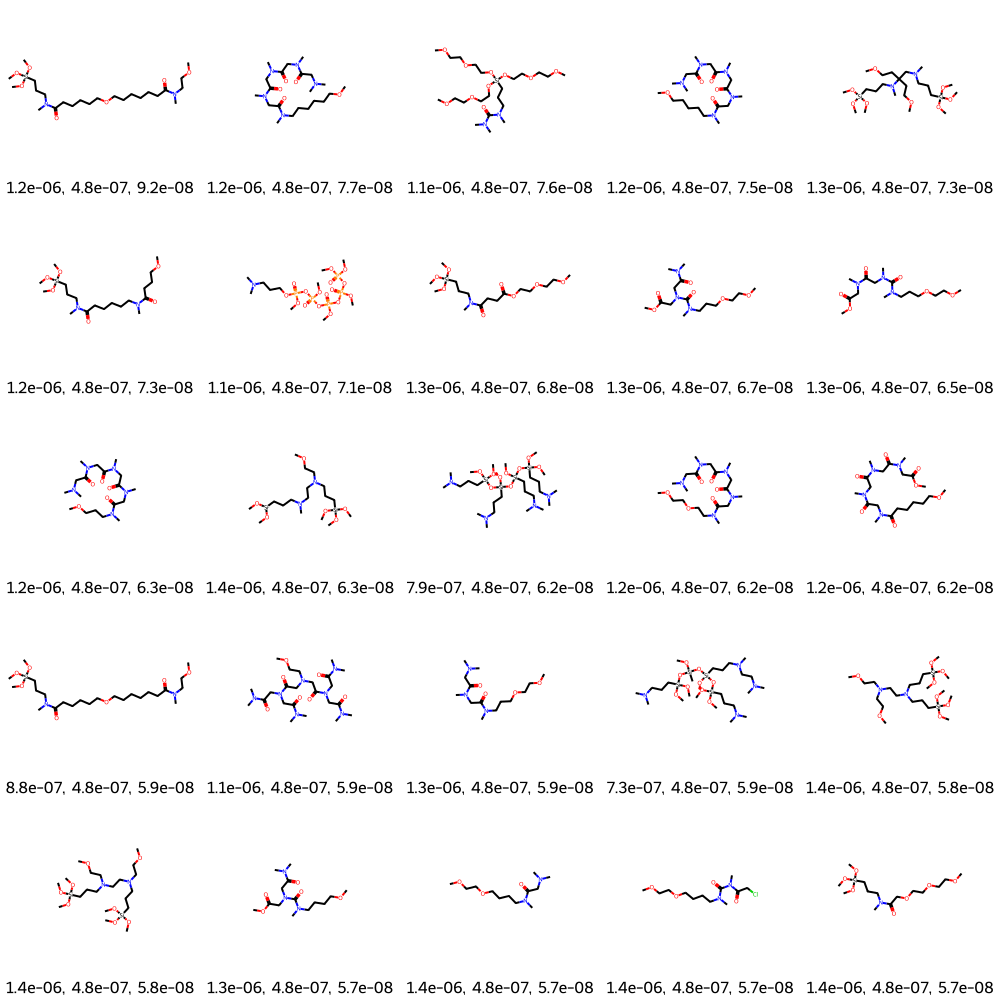

In [77]:
# df_new_['pred_uncertainty'] = df_new_.apply(lambda x: str(round(x['norm_capacity_3_pred'],3)) + ', ' + str(round(x['norm_capacity_3_uncer'],3)) + ', ' + str(round(x['EI_weight_av'],3)), axis=1)
df_new_['pred_comb'] = df_new_.apply(lambda x: str(format(x['norm_capacity_3_pred'],".1e")) + ', ' + str(format(x['norm_capacity_3_uncer'],".1e")) + ', ' + str(format(x['EI_aggr'],".1e")), axis=1)
PandasTools.AddMoleculeColumnToFrame(df_new_, smilesCol='solv_comb_sm')
# PandasTools.FrameToGridImage(df_, legendsCol="norm_capacity_3_pred", molsPerRow=6)
PandasTools.FrameToGridImage(df_new_.iloc[:25], legendsCol="pred_comb", molsPerRow=5)

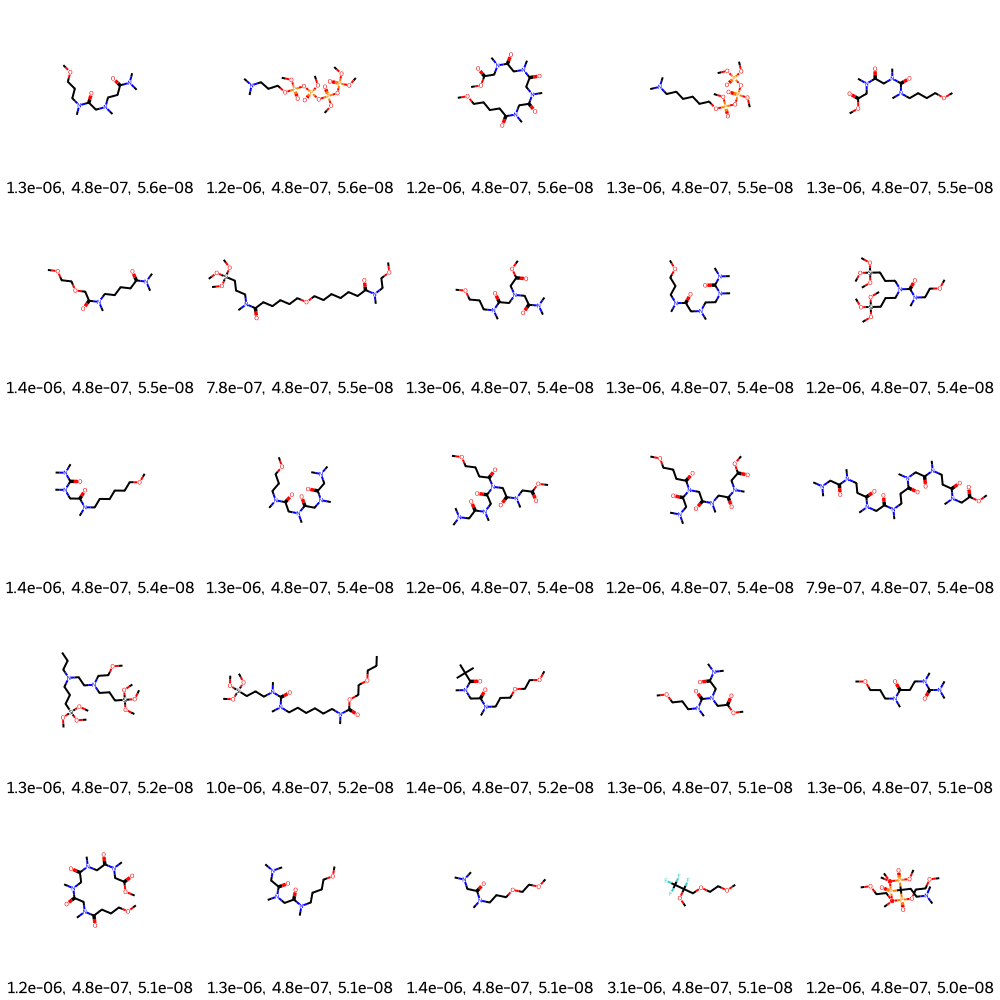

In [78]:
PandasTools.FrameToGridImage(df_new_.iloc[25:50], legendsCol="pred_comb", molsPerRow=5)

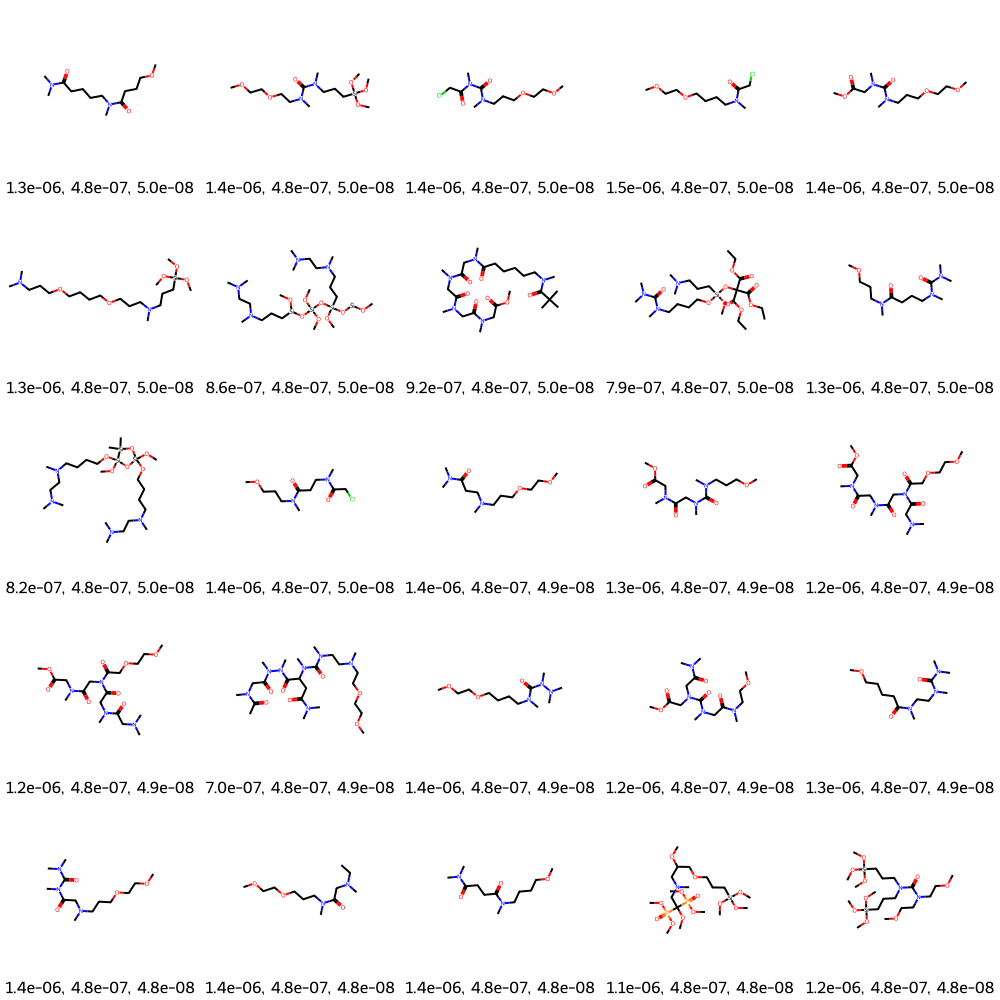

In [79]:
PandasTools.FrameToGridImage(df_new_.iloc[50:75], legendsCol="pred_comb", molsPerRow=5)

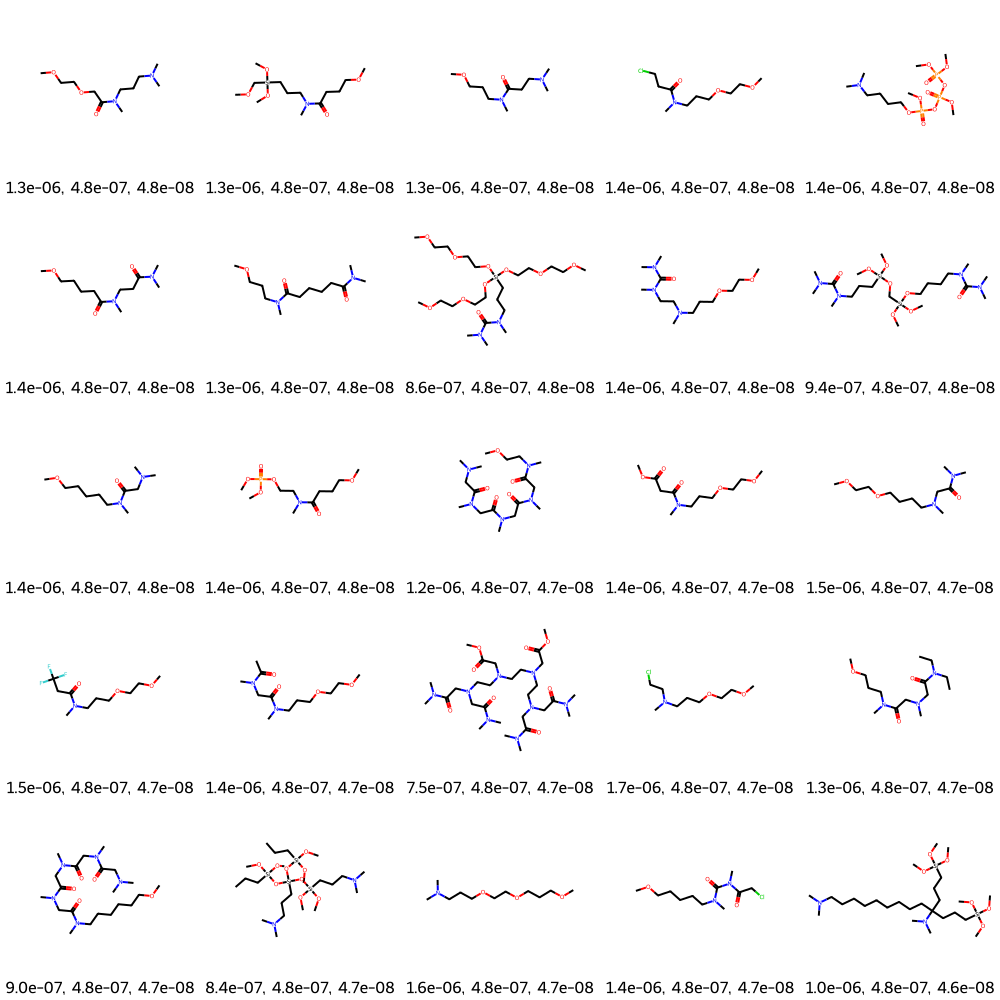

In [80]:
PandasTools.FrameToGridImage(df_new_.iloc[75:100], legendsCol="pred_comb", molsPerRow=5)

In [81]:
%%bash
ls -ltr

total 2544448
-rw-r--r--  1 riteshk  staff  499365396 Nov 23 15:41 unlabel_1mil_ecfp_pca_add_feat_iter_3.csv
-rw-r--r--@ 1 riteshk  staff      15473 Nov 23 15:43 just_label_iter_3.csv
-rw-r--r--@ 1 riteshk  staff      44835 Nov 23 15:45 label_ecfp_pca_add_feat_iter_2_101123.csv
-rw-r--r--@ 1 riteshk  staff      53765 Nov 23 16:14 label_ecfp_pca_add_feat_iter_3_112323.csv
-rw-r--r--  1 riteshk  staff     147657 Nov 23 17:06 pairwise_iter3_112323.pkl
-rw-r--r--  1 riteshk  staff     147632 Nov 23 17:07 matern_iter3_112323.pkl
-rw-r--r--  1 riteshk  staff     147689 Nov 23 17:07 rq_iter3_112323.pkl
-rw-r--r--  1 riteshk  staff     147818 Nov 23 17:07 rbfexpsin_iter3_112323.pkl
-rw-r--r--  1 riteshk  staff  800646693 Nov 23 17:11 preds_uncer_ei_unlabel_1mil_iter3_112323.csv
-rw-r--r--@ 1 riteshk  staff    2011331 Nov 23 17:13 sugg_gpr_bma_iter_3.ipynb


**tSNE for top 5000**

In [82]:
df_new_5000 = df_new.iloc[:5000,:]
df_new_5000

,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,...,norm_capacity_3_un_matern,norm_capacity_3_rq,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr
281976,281990,COCCN(C)C(=O)CCCCCCOCCCCCC(=O)N(C)CCC[Si](OC)(...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.526972,0.762888,-0.043111,0.091130,-0.036244,1.783612,0.528564,...,0.382482,0.187970,0.269315,0.494795,0.380944,0.075755,0.023145,0.003515,0.036239,9.156261e-08
326354,326368,COCCCCCCN(C)C(=O)CN(C)C(=O)CN(C)C(=O)CN(C)C(=O...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.642934,0.583175,-0.193497,0.027452,0.286315,1.477630,0.542843,...,0.357940,0.187759,0.263615,0.502978,0.351917,0.056830,0.018637,0.003102,0.030292,7.669432e-08
306283,306297,COCCOCCO[Si](CCCN(C)C(=O)N(C)C)(OCCOCCOC)OCCOCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.539348,0.339029,0.059888,-0.275322,0.273289,1.190844,0.705424,...,0.369265,0.182751,0.266936,0.484822,0.362438,0.058682,0.019268,0.003178,0.029945,7.619361e-08
266600,266614,COCCCCCN(C)C(=O)CN(C)C(=O)CN(C)C(=O)CN(C)C(=O)...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.642934,0.583175,-0.193497,0.027452,0.286315,1.477630,0.542843,...,0.353047,0.188678,0.262494,0.506568,0.346237,0.054076,0.017996,0.003053,0.029480,7.470511e-08
208312,208324,COCCC(CCOC)(CN(C)CCC[Si](OC)(OC)OC)N(C)CCC[Si]...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.186252,-0.985954,-0.256065,-0.791327,0.030853,0.937182,1.533513,...,0.345958,0.196875,0.262425,0.519606,0.333096,0.049493,0.018319,0.003303,0.028368,7.280541e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312014,312028,COC(=O)CCN(CCC[Si](OC)(OC)OC)CCC[Si](OC)(OC)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.514428,0.686842,0.822691,0.151987,0.241904,0.555405,-0.192641,...,0.298452,0.175705,0.251985,0.359391,0.278107,0.008766,0.004222,0.002081,0.004388,1.669331e-08
256962,256976,CCCCOCCCCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.016323,-1.736026,0.515370,0.855807,-0.916025,1.494011,0.731618,...,0.224846,0.295796,0.210126,0.462700,0.207538,0.005998,0.004037,0.002716,0.002540,1.668868e-08
323437,323451,COC(=O)CCCN(C)CCN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.603914,1.019128,0.141109,-0.004782,0.532943,0.933050,-0.126923,...,0.291285,0.175856,0.246003,0.375040,0.280974,0.008175,0.004128,0.001783,0.005312,1.668720e-08
644762,644788,CCCCN(C)C(=O)COCCOC,[Li+].F[P-](F)(F)(F)(F)F,-1.861340,0.219789,-0.349562,0.725646,0.157948,1.690088,0.412044,...,0.306966,0.159127,0.252023,0.348554,0.292970,0.008408,0.004796,0.001742,0.005258,1.668720e-08


In [83]:
df_new['norm_capacity_3_pred'].min()
df_new_5000['solv_comb_sm'].unique().shape

(4256,)

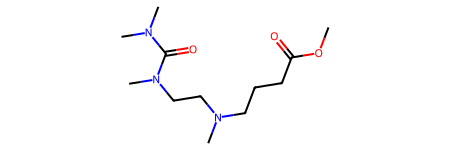

In [84]:
# Chem.MolFromSmiles('COC(C)C(C)(P(=O)(OC)OC)P(=O)(OC)OC')
# Chem.MolFromSmiles('COS(C)(OC)N(C)CC(C)(F)F')
Chem.MolFromSmiles('COC(=O)CCCN(C)CCN(C)C(=O)N(C)C')

In [ ]:
# df_unlabel_uniq_ = df_unlabel_.drop_duplicates(subset=['solv_comb_sm'], keep='first')
# df_unlabel_uniq_

In [22]:
df_comb_tsne = pd.read_csv('../comb_label_unlabel_tsne.csv') ## tsne plot all unique candidate solvent molecules (obtained from 1st iteration of AL)
df_comb_tsne

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1
0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,-0.373535,0.936724,-0.161937,-0.377185,0.259444,...,-0.272648,73.052764,186.939685,1.0,0.0,150,50,2,16.453455,-31.206432
1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,0.728341,0.681048,-1.181697,0.018457,0.793475,...,-0.272648,114.079313,186.939685,1.0,0.0,150,50,2,-33.983090,12.215143
2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,-0.342583,1.301206,-0.264839,-0.516489,0.217482,...,-0.272648,116.094963,186.939685,1.0,0.0,150,50,2,-4.163685,37.835484
3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,-0.113769,0.728616,-0.486733,-0.311699,0.151570,...,-0.272648,70.058995,186.939685,1.0,0.0,150,50,2,24.099570,-31.178453
4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,-0.547668,0.955202,-0.313588,-0.356929,0.299023,...,-0.272648,72.044939,186.939685,1.0,0.0,150,50,2,16.810526,-31.602932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388057,CCOCCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.793309,-1.253349,0.500190,0.218522,0.388077,0.105805,0.067019,0.165620,...,-0.272648,156.025643,186.939685,2.0,0.0,150,50,2,-27.724335,-20.865755
388058,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,-0.272648,111.999429,186.939685,1.0,0.0,150,50,2,-9.939236,35.545410
388059,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,-0.272648,111.999429,186.939685,2.0,0.0,150,50,2,-9.939236,35.545410
388060,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,-0.272648,111.999429,186.939685,4.0,0.0,203,50,1,-9.939253,35.545414


In [87]:
list_suggest_bool = df_comb_tsne['solv_comb_sm'].isin(df_new_5000['solv_comb_sm'])
sugg_ind = [i for i in range(len(list_suggest_bool)) if list_suggest_bool[i] == True]
list_label_pool = df_comb_tsne['solv_comb_sm'].isin(df['solv_comb_sm'])
label_ind = [i for i in range(len(list_label_pool)) if list_label_pool[i] == True]
# sugg_ind_1 = [sugg_ind[i] for i in range(int(len(sugg_ind)/2))]
# sugg_ind_2 = [sugg_ind[i] for i in range(int(len(sugg_ind)/2), len(sugg_ind))]
df_comb_tsne['database'] = 'unlabel'
# df_comb_tsne.loc[sugg_ind_1, 'database'] = 'sugg_3rd_peiyuan'
# df_comb_tsne.loc[sugg_ind_2, 'database'] = 'sugg_3rd_ritesh'
df_comb_tsne.loc[sugg_ind, 'database'] = 'sugg_all'
df_comb_tsne.loc[label_ind, 'database'] = 'label'
df_comb_tsne

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database
0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,-0.373535,0.936724,-0.161937,-0.377185,0.259444,...,73.052764,186.939685,1.0,0.0,150,50,2,16.453455,-31.206432,unlabel
1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,0.728341,0.681048,-1.181697,0.018457,0.793475,...,114.079313,186.939685,1.0,0.0,150,50,2,-33.983090,12.215143,unlabel
2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,-0.342583,1.301206,-0.264839,-0.516489,0.217482,...,116.094963,186.939685,1.0,0.0,150,50,2,-4.163685,37.835484,unlabel
3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,-0.113769,0.728616,-0.486733,-0.311699,0.151570,...,70.058995,186.939685,1.0,0.0,150,50,2,24.099570,-31.178453,unlabel
4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,-0.547668,0.955202,-0.313588,-0.356929,0.299023,...,72.044939,186.939685,1.0,0.0,150,50,2,16.810526,-31.602932,unlabel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388057,CCOCCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.793309,-1.253349,0.500190,0.218522,0.388077,0.105805,0.067019,0.165620,...,156.025643,186.939685,2.0,0.0,150,50,2,-27.724335,-20.865755,label
388058,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,111.999429,186.939685,1.0,0.0,150,50,2,-9.939236,35.545410,label
388059,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,111.999429,186.939685,2.0,0.0,150,50,2,-9.939236,35.545410,label
388060,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,111.999429,186.939685,4.0,0.0,203,50,1,-9.939253,35.545414,label


In [90]:
# df_comb_tsne.loc[df_comb_tsne['database'] == 'sugg_3rd_ritesh']['solv_comb_sm'].unique().shape
df_comb_tsne.loc[df_comb_tsne['database'] == 'sugg_3rd_peiyuan']
# df_comb_tsne.loc[df_comb_tsne['database'] == 'sugg_all']

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database


In [92]:
len(sugg_ind)
# sugg_ind
df_comb_tsne['database'].unique()

array(['unlabel', 'sugg_all', 'label'], dtype=object)

cluster regions rather than assigning randomly

In [94]:
df_comb_tsne_sugg = df_comb_tsne.loc[df_comb_tsne['database'] == 'sugg_all']
X_comb_tsne = df_comb_tsne_sugg.iloc[:,-3:-1]
X_comb_tsne

/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,TSNE_0,TSNE_1
817,20.163671,-7.315735
872,20.788770,-7.305290
1545,20.163263,-7.315250
2106,20.669907,-7.487590
3004,8.165010,19.118220
...,...,...
374433,26.855629,-10.466676
374702,20.067820,-16.946383
380793,-18.864560,8.316939
383544,-18.866081,8.316618


In [106]:
kmeans = KMeans(random_state=0).fit(X_comb_tsne) ## using # of clusters found by kmeans method

/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<AxesSubplot: xlabel='TSNE_0', ylabel='TSNE_1'>

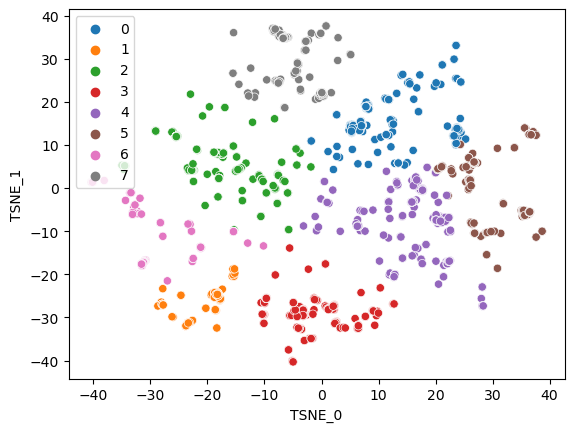

In [107]:
sns.scatterplot(x=df_comb_tsne_sugg['TSNE_0'], y=df_comb_tsne_sugg['TSNE_1'], hue=kmeans.labels_, palette='tab10')

/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<AxesSubplot: xlabel='TSNE_0', ylabel='TSNE_1'>

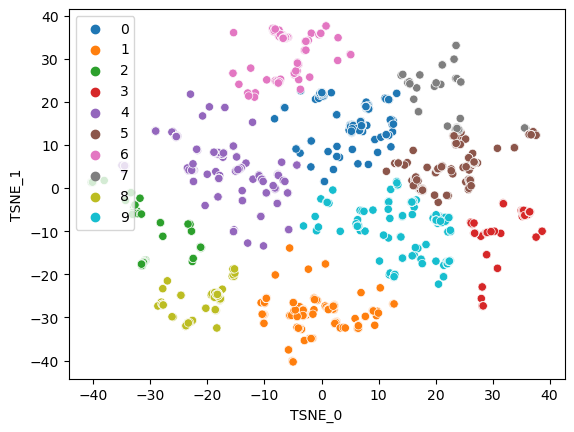

In [96]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_comb_tsne) ## fixing # of clusters to 10
sns.scatterplot(x=df_comb_tsne_sugg['TSNE_0'], y=df_comb_tsne_sugg['TSNE_1'], hue=kmeans.labels_, palette='tab10')

In [108]:
row_label = df_comb_tsne.loc[df_comb_tsne['database'] == 'label']
df_comb_tsne_sugg['database'] = [('sugg_3rd_' + str(kmeans.labels_.astype(str)[i])) for i in range(len(kmeans.labels_))]
df_comb_tsne_ = pd.concat([row_label, df_comb_tsne_sugg], axis=0)
df_comb_tsne_

/var/folders/s5/lmr5dh0n4bsgnpxrzwlts5lw0000gn/T/ipykernel_46644/3614066031.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comb_tsne_sugg['database'] = [('sugg_3rd_' + str(kmeans.labels_.astype(str)[i])) for i in range(len(kmeans.labels_))]


,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database
2373,CN1CCCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.389185,-0.935876,0.111029,0.485331,0.308117,-0.724181,0.398491,0.687894,...,99.104799,186.939685,1.0,0.0,150,50,2,26.357819,-1.480546,label
4139,CCN1CCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.876502,-1.072168,-0.081963,0.736596,0.206000,-0.486059,0.263508,0.370727,...,99.104799,186.939685,1.0,0.0,150,50,2,-27.672503,6.123165,label
6664,CCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.937292,-1.613544,0.672441,0.163123,-0.543020,0.617387,0.624449,0.415481,...,74.073165,186.939685,1.0,0.0,150,50,2,-14.375510,35.692364,label
20398,CC1(C)CCCC(=O)C1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.544321,-0.787394,0.681496,-0.289700,0.458624,0.255901,-0.920301,0.736245,...,126.104465,186.939685,1.0,0.0,150,50,2,6.669382,-13.322131,label
27919,COCC(C)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.094894,-1.404056,0.585391,-0.764865,-1.127708,-0.580104,0.501909,0.331475,...,104.083730,186.939685,1.0,0.0,150,50,2,-21.051500,-31.554310,label
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374433,COC(=O)CN(C)C(=O)CN(C(=O)CCCC(=O)N1CCCCC1)C(=O...,[Li+].F[P-](F)(F)(F)(F)F,-0.333398,1.993839,0.177864,0.453887,0.475709,0.553553,0.469873,0.798286,...,497.284949,151.980186,1.0,0.0,150,50,2,26.855629,-10.466676,sugg_3rd_5
374702,CCCN(CC(=O)N(C)CCN(CC(=O)N(C)CCN(CC(=O)N(C)C)C...,[Li+].F[P-](F)(F)(F)(F)F,-1.048863,0.329044,-1.007147,0.557816,1.327044,0.480681,-0.620533,0.397149,...,540.363533,151.980186,1.0,0.0,150,50,2,20.067820,-16.946383,sugg_3rd_4
380793,COCCOCCOCCCCCN(C)C,[Li+].O=C1O[B-](F)(F)OC1=O,-1.044421,-0.488391,-0.373963,-0.334889,-0.368118,1.633504,0.988119,0.963065,...,233.199094,144.001775,1.0,0.0,150,50,2,-18.864560,8.316939,sugg_3rd_2
383544,COCCOCCOCCOCCCCN(C)C,[Li+].O=C1O[B-](F)(F)OC1=O,-0.983630,-0.449404,-0.385419,-0.493159,-0.323114,1.499980,1.007363,1.016244,...,263.209658,144.001775,1.0,0.0,150,50,2,-18.866081,8.316618,sugg_3rd_2


In [99]:
df_comb_tsne_.to_csv('iter_3_top5000_sugg_ei_unique.csv')

In [119]:
df_comb_tsne['database'].unique()
df_comb_tsne_['database'].unique()

array(['label', 'sugg_3rd_4', 'sugg_3rd_0', 'sugg_3rd_2', 'sugg_3rd_5',
       'sugg_3rd_7', 'sugg_3rd_3', 'sugg_3rd_1', 'sugg_3rd_6'],
      dtype=object)

Interactive tSNE plot (Himi's code)

In [118]:
## pick only rows for label, sugg_2nd_peiyuan, and sugg_2nd_ritesh -> not using it but rather clusters from kmeans
df_comb_tsne__ = df_comb_tsne_.loc[df_comb_tsne['database'] != 'unlabel']
df_comb_tsne__

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database
2373,CN1CCCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.389185,-0.935876,0.111029,0.485331,0.308117,-0.724181,0.398491,0.687894,...,99.104799,186.939685,1.0,0.0,150,50,2,26.357819,-1.480546,label
4139,CCN1CCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.876502,-1.072168,-0.081963,0.736596,0.206000,-0.486059,0.263508,0.370727,...,99.104799,186.939685,1.0,0.0,150,50,2,-27.672503,6.123165,label
6664,CCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.937292,-1.613544,0.672441,0.163123,-0.543020,0.617387,0.624449,0.415481,...,74.073165,186.939685,1.0,0.0,150,50,2,-14.375510,35.692364,label
20398,CC1(C)CCCC(=O)C1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.544321,-0.787394,0.681496,-0.289700,0.458624,0.255901,-0.920301,0.736245,...,126.104465,186.939685,1.0,0.0,150,50,2,6.669382,-13.322131,label
27919,COCC(C)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.094894,-1.404056,0.585391,-0.764865,-1.127708,-0.580104,0.501909,0.331475,...,104.083730,186.939685,1.0,0.0,150,50,2,-21.051500,-31.554310,label
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374433,COC(=O)CN(C)C(=O)CN(C(=O)CCCC(=O)N1CCCCC1)C(=O...,[Li+].F[P-](F)(F)(F)(F)F,-0.333398,1.993839,0.177864,0.453887,0.475709,0.553553,0.469873,0.798286,...,497.284949,151.980186,1.0,0.0,150,50,2,26.855629,-10.466676,sugg_3rd_5
374702,CCCN(CC(=O)N(C)CCN(CC(=O)N(C)CCN(CC(=O)N(C)C)C...,[Li+].F[P-](F)(F)(F)(F)F,-1.048863,0.329044,-1.007147,0.557816,1.327044,0.480681,-0.620533,0.397149,...,540.363533,151.980186,1.0,0.0,150,50,2,20.067820,-16.946383,sugg_3rd_4
380793,COCCOCCOCCCCCN(C)C,[Li+].O=C1O[B-](F)(F)OC1=O,-1.044421,-0.488391,-0.373963,-0.334889,-0.368118,1.633504,0.988119,0.963065,...,233.199094,144.001775,1.0,0.0,150,50,2,-18.864560,8.316939,sugg_3rd_2
383544,COCCOCCOCCOCCCCN(C)C,[Li+].O=C1O[B-](F)(F)OC1=O,-0.983630,-0.449404,-0.385419,-0.493159,-0.323114,1.499980,1.007363,1.016244,...,263.209658,144.001775,1.0,0.0,150,50,2,-18.866081,8.316618,sugg_3rd_2


In [120]:
# df_comb_tsne__['database'].values.tolist()
df_comb_tsne__['database'].unique()

array(['label', 'sugg_3rd_4', 'sugg_3rd_0', 'sugg_3rd_2', 'sugg_3rd_5',
       'sugg_3rd_7', 'sugg_3rd_3', 'sugg_3rd_1', 'sugg_3rd_6'],
      dtype=object)

In [121]:
def _prepareMol(mol,kekulize):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    return mc

def moltosvg(mol,molSize=(250,100),kekulize=True,drawer=None,**kwargs):
    mc = _prepareMol(mol,kekulize)
    if drawer is None:
        drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc,**kwargs)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return SVG(svg.replace('svg:',''))

PandasTools.AddMoleculeColumnToFrame(df_comb_tsne__,'solv_comb_sm', 'solv')

svgs_solv = [moltosvg(m).data for m in df_comb_tsne__.solv]
smile = df_comb_tsne__['solv_comb_sm'].values.tolist()
database_class = df_comb_tsne__['database'].values.tolist()
ind = df_comb_tsne__.index.values.tolist()
ChangeMoleculeRendering(renderer='PNG')

# source = ColumnDataSource(data=dict(x=df_comb_tsne__['TSNE_0'], y=df_comb_tsne__['TSNE_1'], svgs_solv=svgs_solv, desc=database_class, smile=smile, color_column_name=df_comb_tsne__['database']))
source = ColumnDataSource(data=dict(x=df_comb_tsne__['TSNE_0'], y=df_comb_tsne__['TSNE_1'], svgs_solv=svgs_solv, desc=database_class, smile=smile, ind=ind, color=df_comb_tsne__['database'].map({'sugg_3rd_0':'cyan', 'sugg_3rd_1':'orange', 'sugg_3rd_2':'gray',
                                                                                                                                                                                       'sugg_3rd_3':'teal', 'sugg_3rd_4':'green', 'sugg_3rd_5':'yellow', 
                                                                                                                                                                                       'sugg_3rd_6':'red', 'sugg_3rd_7':'purple',
                                                                                                                                                                                       'label':'blue'})))

## original code by Himi
# hover = HoverTool(tooltips="""
#     <div>
#         <div> 
#             <span style="font-size: 17px; font-weight: bold;"> Salt @svgs_salt{safe} </span>
#         </div>
#         <div> 
#             <span style="font-size: 17px; font-weight: bold;"> Solvent @svgs_solv{safe} </span>
#         </div>
#         <div>
#             <span style="font-size: 17px; font-weight: bold;"> Conductivity @desc </span>
#         </div>
#     </div>
#     """
# )

hover = HoverTool(tooltips="""
    <div>
        <div> 
            <span style="font-size: 12px; font-weight: bold;"> @svgs_solv{safe} </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> SMILES: @smile </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> Class: @desc </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> Index: @ind </span>
        </div>
    </div>
    """
)

interactive_map = figure(width=1000, height=1000, tools=['reset,box_zoom,wheel_zoom,zoom_in,zoom_out,pan',hover])
interactive_map.title.text = "Suggestions from AL (iteration-3)"
interactive_map.title.align = "center"
interactive_map.title.text_color = "orange"
interactive_map.title.text_font_size = "25px"

# palette = d3['Category10'][len(df_comb_tsne['database'].unique())]
# color_map = CategoricalColorMapper(factors=df_comb_tsne['database'].unique(),
#                                    palette=palette)
# # interactive_map.circle('x', 'y', hue=, size=6, source=source, fill_alpha=0.2)
# # interactive_map.circle('x', 'y', line_color=mapper, color=mapper, size=6, source=source, fill_alpha=0.2)
# # color_bar = ColorBar(color_mapper=mapper['transform'], width=8)
# # interactive_map.add_layout(color_bar, 'right')
interactive_map.scatter('x', 'y', 
                        # color={'field': df_comb_tsne_['database'], 'transform': color_map},
                        color = 'color',
                        # legend='top_right', ## does not work
                        source=source, size=7, fill_alpha=0.8)
output_file("interactive_map_sugg_al_112323.html")
save(interactive_map)

'/Users/riteshk/Library/CloudStorage/Box-Box/Research-postdoc/AL-CE/08-22-23/campaign-3/interactive_map_sugg_al_112323.html'

In [127]:
me_1 = df_comb_tsne__.loc[df_comb_tsne__['database'] == 'sugg_3rd_0'][['solv_comb_sm', 'TSNE_0', 'TSNE_1', 'database']]
me_2 = df_comb_tsne__.loc[df_comb_tsne__['database'] == 'sugg_3rd_1'][['solv_comb_sm', 'TSNE_0', 'TSNE_1', 'database']]
me_3 = df_comb_tsne__.loc[df_comb_tsne__['database'] == 'sugg_3rd_2'][['solv_comb_sm', 'TSNE_0', 'TSNE_1', 'database']]
me_4 = df_comb_tsne__.loc[df_comb_tsne__['database'] == 'sugg_3rd_3'][['solv_comb_sm', 'TSNE_0', 'TSNE_1', 'database']]
to_me = pd.concat([me_1, me_2, me_3, me_4], axis=0)
to_me

,solv_comb_sm,TSNE_0,TSNE_1,database
3004,CO[Si](CCCCN(C)C(=O)N(C(=O)N(C)C)C(=O)N(C)CCCC...,8.165010,19.118220,sugg_3rd_0
3438,CO[Si](CCCN(C)C(=O)N(C(=O)N(C)C)C(=O)N(C)CCC[S...,8.188257,19.169886,sugg_3rd_0
4001,CCO[Si](CCCN(C)C(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(...,-1.791855,10.948774,sugg_3rd_0
4810,CO[Si](CCCN(C)C(=O)N(C)C)(OC)OC[Si](OC)(OC)OCC...,8.283033,18.338127,sugg_3rd_0
9573,CO[Si](CCCN(C)C(=O)N(CCC[Si](OC)(OC)OC)C(=O)N(...,8.206909,19.229433,sugg_3rd_0
...,...,...,...,...
367467,CCCCC(CCCN(C)C)(CN(C)C)C(CCCC)(CCCC)[Si](OC)(O...,12.724574,-26.861282,sugg_3rd_3
367535,COCCN1CCN(CCCN(C)C(=O)CN(C)C(=O)CN(C)C(=O)CN(C...,2.222466,-27.310150,sugg_3rd_3
368750,CO[Si](C)(CCCSSCCC[Si](C)(OC)OCCN(C)C)OCCN(C)C,-4.948080,-26.543440,sugg_3rd_3
369248,COC(COCCC[Si](OC)(OC)OC)CN(C)CCC[Si](OC)(OC)OC,-9.675708,-25.567408,sugg_3rd_3


In [128]:
peiyuan_1 = df_comb_tsne__.loc[df_comb_tsne__['database'] == 'sugg_3rd_4'][['solv_comb_sm', 'TSNE_0', 'TSNE_1', 'database']]
peiyuan_2 = df_comb_tsne__.loc[df_comb_tsne__['database'] == 'sugg_3rd_5'][['solv_comb_sm', 'TSNE_0', 'TSNE_1', 'database']]
peiyuan_3 = df_comb_tsne__.loc[df_comb_tsne__['database'] == 'sugg_3rd_6'][['solv_comb_sm', 'TSNE_0', 'TSNE_1', 'database']]
peiyuan_4 = df_comb_tsne__.loc[df_comb_tsne__['database'] == 'sugg_3rd_7'][['solv_comb_sm', 'TSNE_0', 'TSNE_1', 'database']]
to_peiyuan = pd.concat([peiyuan_1, peiyuan_2, peiyuan_3, peiyuan_4], axis=0)
to_peiyuan

,solv_comb_sm,TSNE_0,TSNE_1,database
817,CO[Si](CCCN(C)C(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F...,20.163671,-7.315735,sugg_3rd_4
872,CO[Si](CCCN(C)C(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F...,20.788770,-7.305290,sugg_3rd_4
1545,CO[Si](CCCN(C)C(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F...,20.163263,-7.315250,sugg_3rd_4
2106,COC(=O)C(F)(F)C(F)(F)C(F)(F)C(=O)N(C)CCC[Si](O...,20.669907,-7.487590,sugg_3rd_4
3949,CCOCCO[Al],28.191956,-22.931060,sugg_3rd_4
...,...,...,...,...
368723,COC(=O)CN(C)C(=O)CN(C(=O)CCCCCN(C)C)C(=O)CN(C)...,-6.617611,34.803616,sugg_3rd_7
369955,COC(=O)CN(C)C(=O)CN(C)C(=O)CN(C(=O)CCCCCN(C)C)...,-6.617611,34.803616,sugg_3rd_7
371063,COCCCN(C(=O)CN(C)C(=O)CN(C)C(=O)CN(C)C(=O)CN(C...,0.795252,37.594420,sugg_3rd_7
371231,COC(=O)CN(CC(=O)N(C)C)C(=O)CCCCCN(C)C(C)=O,-6.725861,34.727512,sugg_3rd_7


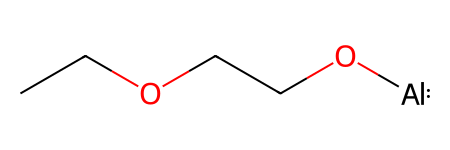

In [129]:
Chem.MolFromSmiles('CCOCCO[Al]')

In [130]:
to_me.to_csv('top5000_1_sugg_list_me_3rd.csv')
to_peiyuan.to_csv('top5000_2_sugg_list_peiyuan_3rd.csv')

In [ ]:
# df_new_5000_uniq = df_new_5000.drop_duplicates(subset=['solv_comb_sm'], keep='first')
# df_new_5000_uniq

In [23]:
## somehow the lengths of dataframes obtained using code is not matching with the one above
# df_new_5000_uniq = df_comb_tsne.loc[df_comb_tsne['database'] == 'suggestions_EI']
# # df_new_5000_uniq.to_csv('top5000_sugg_ei_iter2_101723.csv') ## saving top 5000 suggestions for 2nd iteration of AL (actual number of solvent lower)
# len_df_5000_uniq = len(df_new_5000_uniq)
# to_peiyuan = df_new_5000_uniq.iloc[:int(len_df_5000_uniq/2),:]
# to_me = df_new_5000_uniq.iloc[int(len_df_5000_uniq/2):,:]
# to_me

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database
233439,COCC(C)(N(C)C)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.904553,-1.002129,0.121740,-1.208398,0.522855,0.256292,1.277224,0.357924,...,160.157563,186.939685,1.0,0.0,150,50,2,-16.795280,3.238802,suggestions_EI
233484,COC(C(C)(C)C)C(C)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.831971,-1.447336,0.910930,-0.952117,0.393250,-0.761451,0.887642,-0.329430,...,166.116922,186.939685,1.0,0.0,150,50,2,-23.715467,-18.477345,suggestions_EI
233552,COC(N(C)N(C)C)C(C)(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.895380,-0.916755,-0.113074,-1.335874,0.350350,-0.339785,0.930612,0.156978,...,174.173213,186.939685,1.0,0.0,150,50,2,-13.113187,4.985058,suggestions_EI
233654,COCC(C)(CN(C)Cl)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.874006,-1.026230,0.187408,-1.242342,0.667451,0.277439,1.343890,0.324395,...,181.086956,186.939685,1.0,0.0,150,50,2,-16.818485,3.239529,suggestions_EI
234157,CCC(OC)OC(C)(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.133694,-1.390515,0.514080,-0.502895,0.013895,-0.583223,0.729658,-0.462661,...,146.130680,186.939685,1.0,0.0,150,50,2,-3.061893,9.384779,suggestions_EI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385211,COCCOCCCOCCCCCCCCCCC[Si](OC)(OC)OC,[Li+].O=C1O[B-](F)(F)OC1=O,-0.915870,-0.938476,0.970829,0.044332,-0.738988,0.996804,0.802128,0.293352,...,408.290716,144.001775,1.0,0.0,150,50,2,28.356192,-27.315676,suggestions_EI
385897,CO[Si](CCC(CC[Si](OC)(OC)OC)CC[Si](OC)(OC)OC)(...,[Li+].O=C1O[B-](F)(F)OC1=O,-0.784803,-1.203755,0.512146,-0.385240,-0.676515,-0.570004,0.204125,-0.038398,...,460.198012,144.001775,1.0,0.0,150,50,2,-22.544157,-29.767284,suggestions_EI
385908,COCCC(OC)N(C)C(C)(C)C,[Li+].O=C1O[B-](F)(F)OC1=O,-1.204121,-0.980336,-0.080584,-1.088509,-0.349281,-0.071455,1.546685,0.465116,...,189.172879,144.001775,1.0,0.0,150,50,2,-13.031423,4.894910,suggestions_EI
386563,CO[Si](CCCCC(CCC[Si](OC)(OC)OC)C(C)(C)CC(C)(C)...,[Li+].O=C1O[B-](F)(F)OC1=O,-1.114709,-1.313834,0.572373,-0.257871,-0.122796,-0.486306,0.851936,-0.298315,...,466.314592,144.001775,1.0,0.0,150,50,2,-6.417870,-8.757124,suggestions_EI


In [107]:
## find duplicates in df_new_5000
df_comb_tsne.loc[df_comb_tsne['solv_comb_sm'] == 'COC(C)C(C)(P(=O)(OC)OC)P(=O)(OC)OC']

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database
95568,COC(C)C(C)(P(=O)(OC)OC)P(=O)(OC)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.996998,-1.066859,0.908817,-0.811778,-0.075786,-1.036721,0.652884,-0.237597,...,304.084076,186.939685,1.0,0.0,150,50,2,15.454866,-12.748531,suggestions_EI


**Finding from next 5000: ion 25th Nov**

In [62]:
df_new_5000_ = df_new.iloc[5000:10000,:]
df_new_5000_

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,norm_capacity_3_un_matern,norm_capacity_3_rq,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr
223825,COCC(C)(C)OCCCON(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.258857,-0.638670,0.260863,-0.834764,0.536308,0.668834,1.295097,0.465510,...,0.212812,0.347031,0.213508,0.417822,0.187172,0.006018,0.004088,0.004415,0.001894,1.816914e-08
646991,CCC(C)(COC)OCCOCCOC,[Li+].F[P-](F)(F)(F)(F)F,-1.273627,-1.098582,0.848512,-0.396866,-0.013021,0.084708,1.428949,0.112934,...,0.211389,0.225642,0.236209,0.468820,0.170561,0.007509,0.004233,0.001981,0.002297,1.816747e-08
86290,COC(F)(Cl)C(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.706776,-1.442102,0.897035,-0.750689,0.264222,-0.651085,0.675836,-0.199691,...,0.174548,0.431550,0.179654,0.457176,0.149404,0.004534,0.003093,0.005392,0.000819,1.816613e-08
966869,CO[Si](C)(CCCOC(C)CN(C)CC(C)OCCC[Si](C)(OC)OC)OC,[Li+].O=C1O[B-](F)(F)OC1=O,-0.985267,-0.951975,-0.489254,-0.797715,-0.631440,-0.232164,0.243338,0.785292,...,0.360269,0.131101,0.293302,0.235782,0.313237,0.011413,0.005975,0.002946,0.005236,1.816356e-08
595767,CO[Si](CCCN(CCC[Si](OC)(OC)OC)C(C)CN(C)C)(OC)OC,[Li+].F[P-](F)(F)(F)(F)F,-1.380963,-0.829135,-1.093799,-0.587355,-0.610121,-0.122699,0.104096,0.420811,...,0.343973,0.173770,0.287405,0.243847,0.304720,0.010078,0.005985,0.003822,0.004823,1.816297e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116297,CCC(COC)(COC)CO[Si],[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.789464,-1.522361,0.798138,-0.319686,0.176442,0.169385,0.879932,0.058852,...,0.170335,0.448415,0.161508,0.435561,0.145464,0.003349,0.002080,0.004195,0.000438,1.396628e-08
46305,COP(=O)(OCCN(C)C)OCC(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.203482,-0.512764,-0.569173,-1.051899,-0.672593,-0.059725,0.460471,0.716609,...,0.248939,0.254642,0.240290,0.348606,0.222323,0.006064,0.003175,0.003022,0.002217,1.396612e-08
486031,COCCC(OC)O[SiH3],[Li+].F[P-](F)(F)(F)(F)F,-0.929270,-1.397598,0.764648,-0.463689,-1.169479,-0.173591,0.801685,0.468475,...,0.213594,0.234330,0.239301,0.429866,0.171428,0.005804,0.003032,0.002368,0.001303,1.396314e-08
60693,CCOCCOC(C)(C)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.028444,-1.454773,0.796553,-0.257764,0.402535,0.300929,1.077131,0.003570,...,0.173357,0.399630,0.166951,0.455691,0.149176,0.004571,0.002737,0.002419,0.000788,1.396150e-08


In [63]:
list_suggest_bool_ = df_comb_tsne['solv_comb_sm'].isin(df_new_5000_['solv_comb_sm'])
sugg_ind_ = [i for i in range(len(list_suggest_bool_)) if list_suggest_bool_[i] == True]
df_comb_tsne.loc[sugg_ind_, 'database'] = 'next_5000'
df_comb_tsne

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database,solv
0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,-0.373535,0.936724,-0.161937,-0.377185,0.259444,...,186.939685,1.0,0.0,150,50,2,16.453455,-31.206432,unlabel,<rdkit.Chem.rdchem.Mol object at 0x178526580>
1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,0.728341,0.681048,-1.181697,0.018457,0.793475,...,186.939685,1.0,0.0,150,50,2,-33.983090,12.215143,unlabel,<rdkit.Chem.rdchem.Mol object at 0x1785267b0>
2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,-0.342583,1.301206,-0.264839,-0.516489,0.217482,...,186.939685,1.0,0.0,150,50,2,-4.163685,37.835484,unlabel,<rdkit.Chem.rdchem.Mol object at 0x1785262e0>
3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,-0.113769,0.728616,-0.486733,-0.311699,0.151570,...,186.939685,1.0,0.0,150,50,2,24.099570,-31.178453,unlabel,<rdkit.Chem.rdchem.Mol object at 0x178526510>
4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,-0.547668,0.955202,-0.313588,-0.356929,0.299023,...,186.939685,1.0,0.0,150,50,2,16.810526,-31.602932,unlabel,<rdkit.Chem.rdchem.Mol object at 0x1785263c0>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388057,CCOCCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.793309,-1.253349,0.500190,0.218522,0.388077,0.105805,0.067019,0.165620,...,186.939685,2.0,0.0,150,50,2,-27.724335,-20.865755,label,<rdkit.Chem.rdchem.Mol object at 0x409dcf510>
388058,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,186.939685,1.0,0.0,150,50,2,-9.939236,35.545410,label,<rdkit.Chem.rdchem.Mol object at 0x409dcf580>
388059,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,186.939685,2.0,0.0,150,50,2,-9.939236,35.545410,label,<rdkit.Chem.rdchem.Mol object at 0x409dcf5f0>
388060,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,186.939685,4.0,0.0,203,50,1,-9.939253,35.545414,label,<rdkit.Chem.rdchem.Mol object at 0x409dcf660>


In [64]:
next_5000 = df_comb_tsne.loc[df_comb_tsne['database'] == 'next_5000']
next_5000.to_csv('iter_2_next5000_after_top5000_sugg_ei_unique.csv')
next_5000

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database,solv
200,COC(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.683551,-1.459390,0.821170,-0.687076,-0.260308,-0.599990,0.156997,0.043598,...,186.939685,1.0,0.0,150,50,2,-33.763535,-20.853682,next_5000,<rdkit.Chem.rdchem.Mol object at 0x2edf946d0>
226,CCCOF,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.751319,-1.772512,0.326835,0.350208,0.166223,0.187497,0.105344,-0.006552,...,186.939685,1.0,0.0,150,50,2,36.825356,-13.333976,next_5000,<rdkit.Chem.rdchem.Mol object at 0x2eddb8270>
872,CO[Si](CCCN(C)C(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.431278,0.458372,0.033057,-0.526323,1.347255,0.546517,0.808674,0.145876,...,186.939685,1.0,0.0,150,50,2,20.788770,-7.305290,next_5000,<rdkit.Chem.rdchem.Mol object at 0x2edb6b190>
1742,CN(C)[Si](N(C)C)(N(C)C)C(F)(F)C(F)(F)C(F)(F)C(...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.251213,-1.283847,-0.272512,-0.839526,1.312295,-0.360988,0.356428,0.117021,...,186.939685,1.0,0.0,150,50,2,35.111572,-2.100883,next_5000,<rdkit.Chem.rdchem.Mol object at 0x2edb47430>
1962,CC[Si](OC)(OC)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.809724,-1.049091,0.880563,-0.215826,0.548067,-0.016855,0.627242,-0.267292,...,186.939685,1.0,0.0,150,50,2,-29.619156,-5.268256,next_5000,<rdkit.Chem.rdchem.Mol object at 0x2edb445f0>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388041,COCCOCC(F)(F)C(F)(F)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.990626,-1.130114,1.217522,-0.578704,0.178735,0.279893,1.365620,0.464585,...,186.939685,1.0,0.0,203,13,2,-33.052480,-5.616631,next_5000,<rdkit.Chem.rdchem.Mol object at 0x409dcedd0>
388042,COCCOCC(F)(F)C(F)(F)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.990626,-1.130114,1.217522,-0.578704,0.178735,0.279893,1.365620,0.464585,...,186.939685,1.0,0.0,203,13,2,-33.052624,-5.616689,next_5000,<rdkit.Chem.rdchem.Mol object at 0x409dcee40>
388045,COCCOCC(F)(F)C(F)(F)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.990626,-1.130114,1.217522,-0.578704,0.178735,0.279893,1.365620,0.464585,...,186.939685,1.0,0.0,161,50,2,-33.052357,-5.616669,next_5000,<rdkit.Chem.rdchem.Mol object at 0x409dcef90>
388046,COCCOCC(F)(F)C(F)(F)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.990626,-1.130114,1.217522,-0.578704,0.178735,0.279893,1.365620,0.464585,...,186.939685,1.0,0.0,161,50,2,-33.052480,-5.616615,next_5000,<rdkit.Chem.rdchem.Mol object at 0x409dcf040>


**tSNE for next 5000: on 25th Nov**

In [138]:
df_next_5000 = df_new.iloc[5000:10000,:]
df_next_5000

,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,...,norm_capacity_3_un_matern,norm_capacity_3_rq,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr
303254,303268,CO[Si](C)(C)CCCN(C)CCN(C)CCC[Si](OC)(OC)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.876518,-0.880058,-0.307256,-0.606861,0.080624,0.713087,0.213711,...,0.294507,0.198792,0.245660,0.341075,0.289767,0.008545,0.004238,0.002271,0.004659,1.668496e-08
835836,835873,COCCOCCCN(C)C(=O)CC(C)=O,[Li+].O=C1O[B-](F)(F)OC1=O,-1.350105,0.801486,0.093762,-0.242729,0.031267,1.513534,0.607639,...,0.319936,0.119684,0.255146,0.329635,0.308226,0.009237,0.004714,0.001229,0.005853,1.668311e-08
48267,48271,COP(C)OCCCN(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.992930,-0.939291,-0.539234,-0.585902,0.036458,0.836119,0.559913,...,0.255984,0.228234,0.231474,0.415823,0.247796,0.006568,0.004511,0.002177,0.004032,1.668234e-08
231626,231640,CCCN(C)C(=O)N(C)C(=O)CN(CC(=O)OC)CC(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.412229,1.078227,-0.206249,0.107990,0.404382,1.102843,-0.366141,...,0.312282,0.167119,0.251974,0.330815,0.303155,0.008836,0.004542,0.001898,0.005426,1.668179e-08
468004,468028,COCCOCCOCCOCCOCCOCCOCCC[Si](OC)(OC)OC,[Li+].F[P-](F)(F)(F)(F)F,-0.827387,-0.889886,0.949689,-0.156795,-0.668012,0.799543,0.823534,...,0.302316,0.164545,0.254693,0.360370,0.275162,0.008399,0.004904,0.001980,0.004180,1.667900e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332360,332374,CCN(CC)C(=O)N(C)CCCCOC(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.720069,0.280144,-1.026716,0.138706,0.172035,0.233381,-0.295570,...,0.291450,0.206159,0.243133,0.318926,0.288273,0.004749,0.003528,0.002307,0.003735,1.225235e-08
306154,306168,COCCOCCOC(=O)N(C)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.299140,0.331725,0.497952,-0.561529,0.093772,0.673535,0.571798,...,0.239856,0.215317,0.227120,0.405404,0.228296,0.004712,0.003333,0.001658,0.002259,1.225200e-08
163239,163249,CCCN(C)C(=O)N(C)CCC(=O)N(C)CC(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.242395,0.433762,-0.995629,0.566315,1.310767,0.653439,-0.745401,...,0.319400,0.174055,0.252132,0.264419,0.315889,0.006084,0.003420,0.002052,0.003971,1.225192e-08
164794,164804,CCC(COC)(COC)COP(=O)(OC)OP(=O)(OC)OP(=O)(OC)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.915369,-1.237566,0.998211,-0.221131,0.179714,0.209377,0.911732,...,0.257931,0.197103,0.238451,0.371786,0.238567,0.005625,0.003127,0.001844,0.002027,1.225149e-08


In [139]:
list_suggest_bool_ = df_comb_tsne['solv_comb_sm'].isin(df_next_5000['solv_comb_sm'])
sugg_ind_ = [i for i in range(len(list_suggest_bool_)) if list_suggest_bool_[i] == True]
# list_label_pool_ = df_comb_tsne['solv_comb_sm'].isin(df['solv_comb_sm'])
# label_ind_ = [i for i in range(len(list_label_pool_)) if list_label_pool_[i] == True]
df_comb_tsne.loc[sugg_ind_, 'database'] = 'next_5000'
df_comb_tsne

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database
0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,-0.373535,0.936724,-0.161937,-0.377185,0.259444,...,73.052764,186.939685,1.0,0.0,150,50,2,16.453455,-31.206432,unlabel
1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,0.728341,0.681048,-1.181697,0.018457,0.793475,...,114.079313,186.939685,1.0,0.0,150,50,2,-33.983090,12.215143,unlabel
2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,-0.342583,1.301206,-0.264839,-0.516489,0.217482,...,116.094963,186.939685,1.0,0.0,150,50,2,-4.163685,37.835484,unlabel
3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,-0.113769,0.728616,-0.486733,-0.311699,0.151570,...,70.058995,186.939685,1.0,0.0,150,50,2,24.099570,-31.178453,unlabel
4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,-0.547668,0.955202,-0.313588,-0.356929,0.299023,...,72.044939,186.939685,1.0,0.0,150,50,2,16.810526,-31.602932,unlabel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388057,CCOCCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.793309,-1.253349,0.500190,0.218522,0.388077,0.105805,0.067019,0.165620,...,156.025643,186.939685,2.0,0.0,150,50,2,-27.724335,-20.865755,label
388058,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,111.999429,186.939685,1.0,0.0,150,50,2,-9.939236,35.545410,label
388059,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,111.999429,186.939685,2.0,0.0,150,50,2,-9.939236,35.545410,label
388060,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,111.999429,186.939685,4.0,0.0,203,50,1,-9.939253,35.545414,label


In [141]:
df_comb_tsne_sugg_ = df_comb_tsne.loc[df_comb_tsne['database'] == 'next_5000']
X_comb_tsne_ = df_comb_tsne_sugg_.iloc[:,-3:-1]
X_comb_tsne_

,TSNE_0,TSNE_1
817,20.163671,-7.315735
872,20.788770,-7.305290
1814,28.199804,-22.973871
2178,-15.447232,9.730655
2456,28.259565,-22.987530
...,...,...
386907,6.185858,-8.745185
386994,6.494402,-8.795191
387287,-18.864717,8.314270
387396,15.681972,-3.323443


In [142]:
kmeans_ = KMeans(random_state=0).fit(X_comb_tsne_) ## using # of clusters found by kmeans method

/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<AxesSubplot: xlabel='TSNE_0', ylabel='TSNE_1'>

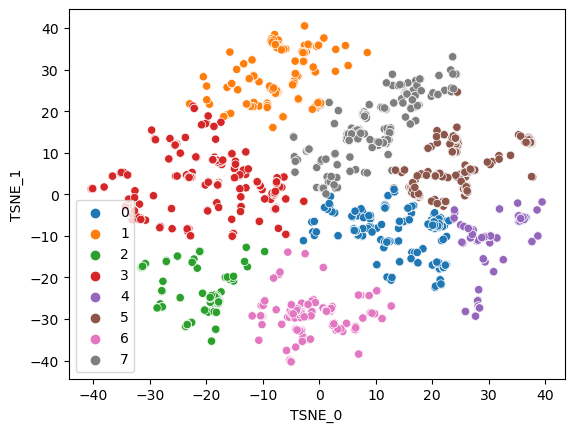

In [143]:
sns.scatterplot(x=df_comb_tsne_sugg_['TSNE_0'], y=df_comb_tsne_sugg_['TSNE_1'], hue=kmeans_.labels_, palette='tab10')

In [147]:
df_comb_tsne_sugg_['database'] = [('next_5000_' + str(kmeans_.labels_.astype(str)[i])) for i in range(len(kmeans_.labels_))]
df_comb_tsne_n = pd.concat([row_label, df_comb_tsne_sugg_], axis=0)
df_comb_tsne_n

/var/folders/s5/lmr5dh0n4bsgnpxrzwlts5lw0000gn/T/ipykernel_46644/3449796556.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comb_tsne_sugg_['database'] = [('next_5000_' + str(kmeans_.labels_.astype(str)[i])) for i in range(len(kmeans_.labels_))]


,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database
2373,CN1CCCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.389185,-0.935876,0.111029,0.485331,0.308117,-0.724181,0.398491,0.687894,...,99.104799,186.939685,1.0,0.0,150,50,2,26.357819,-1.480546,label
4139,CCN1CCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.876502,-1.072168,-0.081963,0.736596,0.206000,-0.486059,0.263508,0.370727,...,99.104799,186.939685,1.0,0.0,150,50,2,-27.672503,6.123165,label
6664,CCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.937292,-1.613544,0.672441,0.163123,-0.543020,0.617387,0.624449,0.415481,...,74.073165,186.939685,1.0,0.0,150,50,2,-14.375510,35.692364,label
20398,CC1(C)CCCC(=O)C1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.544321,-0.787394,0.681496,-0.289700,0.458624,0.255901,-0.920301,0.736245,...,126.104465,186.939685,1.0,0.0,150,50,2,6.669382,-13.322131,label
27919,COCC(C)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.094894,-1.404056,0.585391,-0.764865,-1.127708,-0.580104,0.501909,0.331475,...,104.083730,186.939685,1.0,0.0,150,50,2,-21.051500,-31.554310,label
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386907,CCCN(C)CCCCOCCOC,[Li+].O=C1O[B-](F)(F)OC1=O,-1.200232,-0.716220,-0.632898,0.237957,-0.464196,1.822570,0.894457,0.749287,...,203.188529,144.001775,1.0,0.0,150,50,2,6.185858,-8.745185,next_5000_0
386994,COCCN(C)CCC[Si](COC)(OC)OC,[Li+].O=C1O[B-](F)(F)OC1=O,-1.029200,-0.997617,-0.280489,-0.503384,-0.357378,1.088322,1.093044,1.384092,...,265.170935,144.001775,1.0,0.0,150,50,2,6.494402,-8.795191,next_5000_0
387287,COCCOCCCN(C)CCCCl,[Li+].O=C1O[B-](F)(F)OC1=O,-0.951036,-0.576891,-0.254395,-0.465784,-0.325791,1.397665,1.032146,0.948021,...,223.133907,144.001775,1.0,0.0,150,50,2,-18.864717,8.314270,next_5000_3
387396,CCCCOCCN(CCC[Si](OC)(OC)OC)CCOC,[Li+].O=C1O[B-](F)(F)OC1=O,-1.164254,-1.313408,-0.158492,0.408141,-0.805483,1.630553,0.830279,0.463970,...,337.228450,144.001775,1.0,0.0,150,50,2,15.681972,-3.323443,next_5000_0


In [146]:
df_comb_tsne_sugg_.to_csv('iter_3_next5000_sugg_ei_unique.csv')

In [151]:
df_comb_tsne_n['database'].unique()

array(['label', 'next_5000_0', 'next_5000_4', 'next_5000_3',
       'next_5000_5', 'next_5000_7', 'next_5000_1', 'next_5000_6',
       'next_5000_2'], dtype=object)

In [154]:
def _prepareMol(mol,kekulize):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    return mc

def moltosvg(mol,molSize=(250,100),kekulize=True,drawer=None,**kwargs):
    mc = _prepareMol(mol,kekulize)
    if drawer is None:
        drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc,**kwargs)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return SVG(svg.replace('svg:',''))

PandasTools.AddMoleculeColumnToFrame(df_comb_tsne_n,'solv_comb_sm', 'solv')

svgs_solv = [moltosvg(m).data for m in df_comb_tsne_n.solv]
smile = df_comb_tsne_n['solv_comb_sm'].values.tolist()
database_class = df_comb_tsne_n['database'].values.tolist()
ind = df_comb_tsne_n.index.values.tolist()
ChangeMoleculeRendering(renderer='PNG')

# source = ColumnDataSource(data=dict(x=df_comb_tsne__['TSNE_0'], y=df_comb_tsne__['TSNE_1'], svgs_solv=svgs_solv, desc=database_class, smile=smile, color_column_name=df_comb_tsne__['database']))
source = ColumnDataSource(data=dict(x=df_comb_tsne_n['TSNE_0'], y=df_comb_tsne_n['TSNE_1'], svgs_solv=svgs_solv, desc=database_class, smile=smile, ind=ind, color=df_comb_tsne_n['database'].map({'next_5000_0':'cyan', 'next_5000_1':'orange', 'next_5000_2':'gray',
                                                                                                                                                                                       'next_5000_3':'teal', 'next_5000_4':'green', 'next_5000_5':'yellow', 
                                                                                                                                                                                       'next_5000_6':'red', 'next_5000_7':'purple',
                                                                                                                                                                                       'label':'blue'})))

hover = HoverTool(tooltips="""
    <div>
        <div> 
            <span style="font-size: 12px; font-weight: bold;"> @svgs_solv{safe} </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> SMILES: @smile </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> Class: @desc </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> Index: @ind </span>
        </div>
    </div>
    """
)

interactive_map = figure(width=1000, height=1000, tools=['reset,box_zoom,wheel_zoom,zoom_in,zoom_out,pan',hover])
interactive_map.title.text = "Suggestions from AL (iteration-3; next 5000)"
interactive_map.title.align = "center"
interactive_map.title.text_color = "orange"
interactive_map.title.text_font_size = "25px"

# palette = d3['Category10'][len(df_comb_tsne['database'].unique())]
# color_map = CategoricalColorMapper(factors=df_comb_tsne['database'].unique(),
#                                    palette=palette)
# # interactive_map.circle('x', 'y', hue=, size=6, source=source, fill_alpha=0.2)
# # interactive_map.circle('x', 'y', line_color=mapper, color=mapper, size=6, source=source, fill_alpha=0.2)
# # color_bar = ColorBar(color_mapper=mapper['transform'], width=8)
# # interactive_map.add_layout(color_bar, 'right')
interactive_map.scatter('x', 'y', 
                        # color={'field': df_comb_tsne_['database'], 'transform': color_map},
                        color = 'color',
                        # legend='top_right', ## does not work
                        source=source, size=7, fill_alpha=0.8)
output_file("interactive_map_sugg_al_next_5000_112523.html")
save(interactive_map)

'/Users/riteshk/Library/CloudStorage/Box-Box/Research-postdoc/AL-CE/08-22-23/campaign-3/interactive_map_sugg_al_next_5000_112523.html'

In [155]:
me_1_ = df_comb_tsne_n.loc[df_comb_tsne_n['database'] == 'next_5000_0'][['solv_comb_sm', 'TSNE_0', 'TSNE_1', 'database']]
me_2_ = df_comb_tsne_n.loc[df_comb_tsne_n['database'] == 'next_5000_1'][['solv_comb_sm', 'TSNE_0', 'TSNE_1', 'database']]
me_3_ = df_comb_tsne_n.loc[df_comb_tsne_n['database'] == 'next_5000_2'][['solv_comb_sm', 'TSNE_0', 'TSNE_1', 'database']]
me_4_ = df_comb_tsne_n.loc[df_comb_tsne_n['database'] == 'next_5000_3'][['solv_comb_sm', 'TSNE_0', 'TSNE_1', 'database']]
to_me_ = pd.concat([me_1_, me_2_, me_3_, me_4_], axis=0)
to_me_

,solv_comb_sm,TSNE_0,TSNE_1,database
817,CO[Si](CCCN(C)C(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F...,20.163671,-7.315735,next_5000_0
872,CO[Si](CCCN(C)C(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F...,20.788770,-7.305290,next_5000_0
6297,COCCOCN(C)C(=O)N(C)C,14.198602,-16.244967,next_5000_0
6428,CO[Si](CN(C)C(=O)OCC(F)(F)C(F)(F)C(F)(F)C(F)(F...,21.450367,-5.636488,next_5000_0
6750,CCCCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)[Si](O...,21.385866,-20.548735,next_5000_0
...,...,...,...,...
377873,COCCOCCCO[Si]CCCN(C)C,-18.868317,8.314200,next_5000_3
383934,COCCCCOCCOCCN(C)C,-18.820211,8.336507,next_5000_3
384943,COCCOCCCN(C)S(C)(=O)=O,-18.929428,8.309828,next_5000_3
385575,COCCOCCCCOCCCN(C)C,-18.865908,8.316164,next_5000_3


In [156]:
peiyuan_1_ = df_comb_tsne_n.loc[df_comb_tsne_n['database'] == 'next_5000_4'][['solv_comb_sm', 'TSNE_0', 'TSNE_1', 'database']]
peiyuan_2_ = df_comb_tsne_n.loc[df_comb_tsne_n['database'] == 'next_5000_5'][['solv_comb_sm', 'TSNE_0', 'TSNE_1', 'database']]
peiyuan_3_ = df_comb_tsne_n.loc[df_comb_tsne_n['database'] == 'next_5000_6'][['solv_comb_sm', 'TSNE_0', 'TSNE_1', 'database']]
peiyuan_4_ = df_comb_tsne_n.loc[df_comb_tsne_n['database'] == 'next_5000_7'][['solv_comb_sm', 'TSNE_0', 'TSNE_1', 'database']]
to_peiyuan_ = pd.concat([peiyuan_1_, peiyuan_2_, peiyuan_3_, peiyuan_4_], axis=0)
to_peiyuan_

,solv_comb_sm,TSNE_0,TSNE_1,database
1814,CCOCCOF,28.199804,-22.973871,next_5000_4
2456,CCOOOP,28.259565,-22.987530,next_5000_4
3649,CO[Si](CCCN(C)C(=O)N1CCN(C(=O)N(C)CCC[Si](OC)(...,26.486301,-8.413360,next_5000_4
5779,CCOCCOCl,28.187107,-22.949541,next_5000_4
6550,CCOCCP,28.204210,-22.921993,next_5000_4
...,...,...,...,...
367724,CO[Si](CCCCCCCCN(C)C)(OC)OCCCN(C)C,11.349624,12.392738,next_5000_7
368002,CN(C)N(C)C(=O)CC(=O)N(C)N(C)CCCCCCN(C)N(C)C(=O...,7.340474,14.689404,next_5000_7
371292,CCCC(=O)N(C)CCOCCOCC(=O)N(C)CC(=O)N(C)C,5.265204,12.975017,next_5000_7
371297,COC(=O)CN(C(=O)CN(C)C(=O)CN(C)C(=O)CN(C)C(=O)C...,10.540141,12.532726,next_5000_7


In [160]:
to_me_.to_csv('next5000_1_sugg_list_peiyuan_3rd.csv')
to_peiyuan_.to_csv('next5000_2_sugg_list_me_3rd.csv')

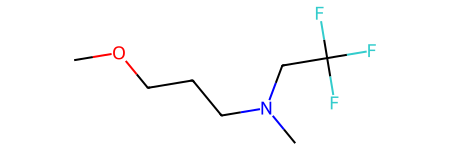

In [21]:
Chem.MolFromSmiles('CCOCCOF')
Chem.MolFromSmiles('CCOOOP')
Chem.MolFromSmiles('CCOCCP')
Chem.MolFromSmiles('CCOC(=O)CN(C)CCOC')
Chem.MolFromSmiles('COC(=O)CCN(C)C(=O)CN(C)C')
Chem.MolFromSmiles('COCCCC(=O)N(C)C')
Chem.MolFromSmiles('FC1(F)CCCC1')
Chem.MolFromSmiles('COCCOCCCCN(C)C(=O)N(C)C(=O)CCl')
Chem.MolFromSmiles('COCCOCCOCC(F)(F)C(F)F')
Chem.MolFromSmiles('COCCCN([S](C)(=O)=O)C')
Chem.MolFromSmiles('COCCCN(C)[S](OC)(=O)=O')
Chem.MolFromSmiles('COCCCN(CC([F])([F])[F])C')

In [165]:
to_me_ = pd.read_csv('./next5000_2_sugg_list_me_3rd.csv')
to_me_emol = pd.read_csv('./emol_next_5000_me.csv')
to_me_emol['smiles'] = to_me_emol['smiles'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x)))
to_me_emol

,smiles
0,COCCCOCCS(=O)(=O)Cl
1,COCCOCCOCCCCCCCCCCC[Si](OC)(OC)OC
2,COCCCC(=O)N(C)C
3,COC(=O)CCN(C)C(=O)CN(C)C
4,CCOC(=O)CN(C)CCOC
5,CCOP(=O)(CCCCN(C)C)OCC
6,CN(C)CCOCCOCCN(C)C


In [168]:
emol_me_bool = to_me_['solv_comb_sm'].isin(to_me_emol['smiles'])
emol_me_ind = [i for i in range(len(emol_me_bool)) if emol_me_bool[i] == True]
to_me_.iloc[emol_me_ind]

,Unnamed: 0,solv_comb_sm,TSNE_0,TSNE_1,database
253,262712,COCCCOCCS(=O)(=O)Cl,28.331768,-27.414627,next_5000_4
420,355646,COCCOCCOCCCCCCCCCCC[Si](OC)(OC)OC,28.356445,-27.317333,next_5000_4
437,3775,COCCCC(=O)N(C)C,26.137825,1.751998,next_5000_5
537,123933,COC(=O)CCN(C)C(=O)CN(C)C,23.739271,14.049875,next_5000_5
1047,331858,CCOC(=O)CN(C)CCOC,26.077414,1.046077,next_5000_5
1106,48829,CCOP(=O)(CCCCN(C)C)OCC,-1.567648,-29.244917,next_5000_6
1379,211998,CN(C)CCOCCOCCN(C)C,6.966732,-38.435352,next_5000_6


In [ ]:
262712	
355646
48829	
211998
331858
123933
3775

**File requested by Peiyuan: top 1000 with MW < 300 (11-28-23)**

In [4]:
df_pred = pd.read_csv('preds_uncer_ei_unlabel_1mil_iter3_112323.csv')
df_pred.sort_values(by=['EI_aggr'], ascending=False, inplace=True)
df_pred

,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,...,norm_capacity_3_un_matern,norm_capacity_3_rq,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr
281966,281990,COCCN(C)C(=O)CCCCCCOCCCCCC(=O)N(C)CCC[Si](OC)(...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.526972,0.762888,-0.043111,0.091130,-0.036244,1.783612,0.528564,...,0.382482,0.187970,0.269315,0.494795,0.380944,7.575470e-02,2.314500e-02,3.514987e-03,3.623937e-02,9.156261e-08
326343,326368,COCCCCCCN(C)C(=O)CN(C)C(=O)CN(C)C(=O)CN(C)C(=O...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.642934,0.583175,-0.193497,0.027452,0.286315,1.477630,0.542843,...,0.357940,0.187759,0.263615,0.502978,0.351917,5.683049e-02,1.863692e-02,3.101636e-03,3.029163e-02,7.669432e-08
306272,306297,COCCOCCO[Si](CCCN(C)C(=O)N(C)C)(OCCOCCOC)OCCOCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.539348,0.339029,0.059888,-0.275322,0.273289,1.190844,0.705424,...,0.369265,0.182751,0.266936,0.484822,0.362438,5.868211e-02,1.926822e-02,3.177950e-03,2.994509e-02,7.619361e-08
266590,266614,COCCCCCN(C)C(=O)CN(C)C(=O)CN(C)C(=O)CN(C)C(=O)...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.642934,0.583175,-0.193497,0.027452,0.286315,1.477630,0.542843,...,0.353047,0.188678,0.262494,0.506568,0.346237,5.407644e-02,1.799590e-02,3.052717e-03,2.947963e-02,7.470511e-08
208303,208324,COCCC(CCOC)(CN(C)CCC[Si](OC)(OC)OC)N(C)CCC[Si]...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.186252,-0.985954,-0.256065,-0.791327,0.030853,0.937182,1.533513,...,0.345958,0.196875,0.262425,0.519606,0.333096,4.949275e-02,1.831915e-02,3.302739e-03,2.836840e-02,7.280541e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678196,678244,FC1(F)CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.617907,-1.406775,0.416785,-0.741919,0.390935,-0.492193,-0.886565,...,0.193429,-0.001741,0.154260,-0.073211,0.171982,9.640444e-08,2.181748e-07,1.475036e-07,1.245403e-09,6.197246e-13
741968,742026,CC1(Cl)CCCS1,[Li+].O=C1O[B-](F)(F)OC1=O,0.820430,-1.467499,0.619549,-0.560647,0.509421,-0.170830,-0.951468,...,0.192109,-0.002029,0.145920,-0.058733,0.171363,1.616123e-07,2.583678e-07,3.938913e-08,1.795079e-09,5.941302e-13
471147,471190,FC1(F)CCCCCCC1,[Li+].F[P-](F)(F)(F)(F)F,0.680281,-1.383992,0.402121,-0.769924,0.378534,-0.445670,-0.916712,...,0.192263,-0.000231,0.133738,-0.042478,0.171610,2.041721e-07,2.527904e-07,4.088585e-09,3.186667e-09,5.845695e-13
442664,442704,CC1(Cl)CCCS1,[Li+].F[P-](F)(F)(F)(F)F,0.820430,-1.467499,0.619549,-0.560647,0.509421,-0.170830,-0.951468,...,0.191066,-0.002474,0.145789,-0.052761,0.170963,1.972256e-07,2.038032e-07,3.793015e-08,2.033288e-09,5.665876e-13


In [28]:
df_pred['rank'] = df_pred['EI_aggr'].rank(ascending=False) ## rank in descending order
df_pred

,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,...,norm_capacity_3_rq,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr,rank
281966,281990,COCCN(C)C(=O)CCCCCCOCCCCCC(=O)N(C)CCC[Si](OC)(...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.526972,0.762888,-0.043111,0.091130,-0.036244,1.783612,0.528564,...,0.187970,0.269315,0.494795,0.380944,7.575470e-02,2.314500e-02,3.514987e-03,3.623937e-02,9.156261e-08,1.0
326343,326368,COCCCCCCN(C)C(=O)CN(C)C(=O)CN(C)C(=O)CN(C)C(=O...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.642934,0.583175,-0.193497,0.027452,0.286315,1.477630,0.542843,...,0.187759,0.263615,0.502978,0.351917,5.683049e-02,1.863692e-02,3.101636e-03,3.029163e-02,7.669432e-08,2.0
306272,306297,COCCOCCO[Si](CCCN(C)C(=O)N(C)C)(OCCOCCOC)OCCOCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.539348,0.339029,0.059888,-0.275322,0.273289,1.190844,0.705424,...,0.182751,0.266936,0.484822,0.362438,5.868211e-02,1.926822e-02,3.177950e-03,2.994509e-02,7.619361e-08,3.0
266590,266614,COCCCCCN(C)C(=O)CN(C)C(=O)CN(C)C(=O)CN(C)C(=O)...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.642934,0.583175,-0.193497,0.027452,0.286315,1.477630,0.542843,...,0.188678,0.262494,0.506568,0.346237,5.407644e-02,1.799590e-02,3.052717e-03,2.947963e-02,7.470511e-08,4.0
208303,208324,COCCC(CCOC)(CN(C)CCC[Si](OC)(OC)OC)N(C)CCC[Si]...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.186252,-0.985954,-0.256065,-0.791327,0.030853,0.937182,1.533513,...,0.196875,0.262425,0.519606,0.333096,4.949275e-02,1.831915e-02,3.302739e-03,2.836840e-02,7.280541e-08,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678196,678244,FC1(F)CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.617907,-1.406775,0.416785,-0.741919,0.390935,-0.492193,-0.886565,...,-0.001741,0.154260,-0.073211,0.171982,9.640444e-08,2.181748e-07,1.475036e-07,1.245403e-09,6.197246e-13,999926.0
741968,742026,CC1(Cl)CCCS1,[Li+].O=C1O[B-](F)(F)OC1=O,0.820430,-1.467499,0.619549,-0.560647,0.509421,-0.170830,-0.951468,...,-0.002029,0.145920,-0.058733,0.171363,1.616123e-07,2.583678e-07,3.938913e-08,1.795079e-09,5.941302e-13,999927.0
471147,471190,FC1(F)CCCCCCC1,[Li+].F[P-](F)(F)(F)(F)F,0.680281,-1.383992,0.402121,-0.769924,0.378534,-0.445670,-0.916712,...,-0.000231,0.133738,-0.042478,0.171610,2.041721e-07,2.527904e-07,4.088585e-09,3.186667e-09,5.845695e-13,999928.0
442664,442704,CC1(Cl)CCCS1,[Li+].F[P-](F)(F)(F)(F)F,0.820430,-1.467499,0.619549,-0.560647,0.509421,-0.170830,-0.951468,...,-0.002474,0.145789,-0.052761,0.170963,1.972256e-07,2.038032e-07,3.793015e-08,2.033288e-09,5.665876e-13,999929.0


In [19]:
df_low_mw = df_pred.loc[df_pred['mol_wt_solv'] <= 300].drop_duplicates(subset=['solv_comb_sm'], keep='first')
df_low_mw

,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,...,norm_capacity_3_rq,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr,rank
308919,308944,COCCOCCCCN(C)C(=O)CN(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.336661,0.674032,-0.280308,-0.163198,0.148098,1.626789,0.705458,...,0.205477,0.250785,0.530940,0.302957,3.174156e-02,1.338163e-02,2.763432e-03,2.295623e-02,5.679284e-08,23.0
328649,328674,COCCOCCCCN(C)C(=O)N(C)C(=O)CCl,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.293644,0.566338,-0.135333,-0.172533,0.093215,1.593875,0.662879,...,0.206522,0.249846,0.537411,0.293272,3.131774e-02,1.300195e-02,2.731970e-03,2.168511e-02,5.655524e-08,24.0
320606,320631,COCCCN(C)C(=O)CN(C)CCC(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.654820,0.732419,-0.186912,-0.064044,0.342462,1.364558,0.528045,...,0.194037,0.253951,0.514553,0.312622,3.351635e-02,1.316262e-02,2.646877e-03,2.278490e-02,5.627251e-08,26.0
304975,305000,COCCOCC(=O)N(C)CCCCC(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.716766,0.693781,-0.084404,0.016856,0.366888,1.429730,0.491781,...,0.195987,0.252777,0.520887,0.303860,3.222542e-02,1.264006e-02,2.626227e-03,2.171718e-02,5.530289e-08,31.0
299863,299888,COCCCCCCN(C)C(=O)CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.678935,0.609334,-0.095133,-0.013704,0.303443,1.473438,0.505132,...,0.197413,0.251630,0.521777,0.299551,3.103813e-02,1.235011e-02,2.593221e-03,2.088717e-02,5.408925e-08,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
882620,882687,BC1(C)CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.767836,-1.447923,0.619568,-0.633468,0.503057,-0.063610,-0.993267,...,0.000778,0.172942,-0.063353,0.174567,1.665944e-07,3.703272e-07,1.605307e-06,2.719183e-09,2.822344e-12,999513.0
953551,953619,O=C1CCC2(CCCCS2)CC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.869855,-1.141136,0.980343,-0.269667,0.789873,-0.297611,-1.190809,...,0.005427,0.163453,-0.040052,0.179789,4.416892e-07,9.211510e-07,6.196662e-07,1.294919e-08,2.555359e-12,999559.0
981426,981494,CC12CCCC(F)(CC1)CC2,[Li+].O=C1O[B-](F)(F)OC1=O,0.746890,-1.413161,0.637293,-0.630554,0.591712,-0.122630,-0.867561,...,-0.001305,0.156384,-0.045444,0.171543,2.280097e-07,3.479975e-07,2.023812e-07,2.861418e-09,1.027874e-12,999870.0
828420,828485,[Si]C1([Si])CCCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.813155,-1.421234,0.552128,-0.622831,0.491489,-0.021924,-0.949165,...,-0.000340,0.133646,-0.028350,0.169728,2.724705e-07,3.855281e-07,3.990538e-09,3.632449e-09,8.444911e-13,999900.0


In [20]:
top_1000_uniq = df_low_mw.iloc[:1000,:]
# top_1000['rank'] = [i for i in range(1,1001)]
# top_1000['mw'] = top_1000['solv_comb_sm'].apply(lambda x: rdMolDescriptors.CalcExactMolWt(Chem.MolFromSmiles(x)))
top_1000_uniq['mean_pred'] = top_1000_uniq.apply(lambda x: (x['norm_capacity_3_rq'] + x['norm_capacity_3_matern'] + x['norm_capacity_3_rbfexpsin'] + x['norm_capacity_3_pair'])/4, axis=1)
top_1000_uniq

/var/folders/s5/lmr5dh0n4bsgnpxrzwlts5lw0000gn/T/ipykernel_68342/2305231810.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_1000_uniq['mean_pred'] = top_1000_uniq.apply(lambda x: (x['norm_capacity_3_rq'] + x['norm_capacity_3_matern'] + x['norm_capacity_3_rbfexpsin'] + x['norm_capacity_3_pair'])/4, axis=1)


,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,...,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr,rank,mean_pred
308919,308944,COCCOCCCCN(C)C(=O)CN(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.336661,0.674032,-0.280308,-0.163198,0.148098,1.626789,0.705458,...,0.250785,0.530940,0.302957,0.031742,0.013382,0.002763,0.022956,5.679284e-08,23.0,0.427264
328649,328674,COCCOCCCCN(C)C(=O)N(C)C(=O)CCl,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.293644,0.566338,-0.135333,-0.172533,0.093215,1.593875,0.662879,...,0.249846,0.537411,0.293272,0.031318,0.013002,0.002732,0.021685,5.655524e-08,24.0,0.433167
320606,320631,COCCCN(C)C(=O)CN(C)CCC(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.654820,0.732419,-0.186912,-0.064044,0.342462,1.364558,0.528045,...,0.253951,0.514553,0.312622,0.033516,0.013163,0.002647,0.022785,5.627251e-08,26.0,0.414701
304975,305000,COCCOCC(=O)N(C)CCCCC(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.716766,0.693781,-0.084404,0.016856,0.366888,1.429730,0.491781,...,0.252777,0.520887,0.303860,0.032225,0.012640,0.002626,0.021717,5.530289e-08,31.0,0.419092
299863,299888,COCCCCCCN(C)C(=O)CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.678935,0.609334,-0.095133,-0.013704,0.303443,1.473438,0.505132,...,0.251630,0.521777,0.299551,0.031038,0.012350,0.002593,0.020887,5.408925e-08,36.0,0.420369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332672,332697,COCCOCCN(C)CC(=O)N(C)C(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.696154,0.589133,-0.351037,-0.733344,-0.454881,0.108091,0.477559,...,0.243329,0.422967,0.283149,0.010646,0.006900,0.002441,0.008221,2.420262e-08,1865.0,0.356988
178174,178193,CCCCOP(=O)(OC)ON(C)CCN(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.394226,-0.926776,-0.568927,0.409673,-0.104702,1.361943,0.384678,...,0.238895,0.454122,0.253920,0.011014,0.005700,0.002643,0.006564,2.420094e-08,1866.0,0.385633
238162,238186,CCN(C)C(=O)C(=O)N(C)CCOCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.473288,0.281153,-0.086215,-0.215933,0.151089,1.036473,0.553687,...,0.239077,0.445172,0.264432,0.011287,0.006061,0.002012,0.007292,2.420079e-08,1867.0,0.373635
213347,213369,CCCCOCCCN(C)P(=O)(OC)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.127452,-0.882332,-0.475302,0.409552,-0.360824,1.632316,0.494943,...,0.235900,0.466190,0.243239,0.010479,0.005651,0.002932,0.006021,2.420034e-08,1868.0,0.399227


In [21]:
top_1000_uniq['solv_comb_sm'].unique().shape

(1000,)

In [25]:
list_top_1000_bool = df_comb_tsne['solv_comb_sm'].isin(top_1000_uniq['solv_comb_sm'])
top_1000_ind = [i for i in range(len(list_top_1000_bool)) if list_top_1000_bool[i] == True]
df_comb_tsne.loc[top_1000_ind, 'database'] = 'top_1000'
df_comb_tsne.loc[top_1000_ind]

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database
11483,COCCCN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.467365,0.455105,-0.002142,-0.272471,0.242055,1.141966,0.589054,1.178044,...,174.136828,186.939685,1.0,0.0,150,50,2,-23.407833,-31.353483,top_1000
16089,COCCCN(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.059886,-0.954092,-0.402727,-0.634028,-0.264763,1.128454,0.973081,1.359149,...,117.115364,186.939685,1.0,0.0,150,50,2,6.494154,-8.794989,top_1000
24009,COCCCN(C)CF,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.042556,-1.066831,-0.261827,-0.637035,-0.226290,1.051947,1.076999,1.290270,...,135.105942,186.939685,1.0,0.0,150,50,2,6.499509,-8.788438,top_1000
29946,COP(=O)(OC)OCCCN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.434083,0.411609,-0.009612,-0.237173,0.399295,1.023127,0.375851,1.002269,...,268.118808,186.939685,1.0,0.0,150,50,2,0.703087,-17.570810,top_1000
30492,CCOP(=O)(OCC)N(C)CCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.264286,-0.668926,-0.305171,-0.076662,-0.205559,1.190004,0.708238,1.174421,...,239.128645,186.939685,1.0,0.0,150,50,2,6.208502,-8.807446,top_1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332559,CCN(C)C(=O)CN(C)CCCCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.735126,0.354074,-0.332793,0.348369,0.119716,1.599132,0.478509,1.095515,...,230.199428,186.939685,1.0,0.0,150,50,2,2.507675,-31.166487,top_1000
332613,CCCCOCCCN(C)C(=O)N(C)C(=O)CCl,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.348302,0.196190,-0.790631,0.884124,0.578871,1.566882,-0.145835,0.048658,...,278.139720,186.939685,1.0,0.0,150,50,2,-24.653168,-24.850508,top_1000
332697,COCCOCCN(C)CC(=O)N(C)C(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.696154,0.589133,-0.351037,-0.733344,-0.454881,0.108091,0.477559,0.948571,...,246.194343,186.939685,1.0,0.0,150,50,2,17.328592,-0.314479,top_1000
333104,CCCN(C)C(=O)N(C)CCCOCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.444082,0.277325,-0.391683,0.358161,-0.101473,1.742547,0.569895,0.605484,...,246.194343,186.939685,1.0,0.0,150,50,2,2.343527,-31.393562,top_1000


In [27]:
df_top_1000_tsne = df_comb_tsne.loc[df_comb_tsne['database'] == 'top_1000']
df_top_1000_tsne['rank'] = df_top_1000_tsne['solv_comb_sm'].apply(lambda x: top_1000_uniq.loc[top_1000_uniq['solv_comb_sm'] == x]['rank'].values[0])
df_top_1000_tsne['mean_pred'] = df_top_1000_tsne['solv_comb_sm'].apply(lambda x: top_1000_uniq.loc[top_1000_uniq['solv_comb_sm'] == x]['mean_pred'].values[0])
df_top_1000_tsne['index_0'] = df_top_1000_tsne['solv_comb_sm'].apply(lambda x: top_1000_uniq.loc[top_1000_uniq['solv_comb_sm'] == x]['index_0'].values[0])
df_top_1000_tsne

/var/folders/s5/lmr5dh0n4bsgnpxrzwlts5lw0000gn/T/ipykernel_68342/1247727954.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_1000_tsne['rank'] = df_top_1000_tsne['solv_comb_sm'].apply(lambda x: top_1000_uniq.loc[top_1000_uniq['solv_comb_sm'] == x]['rank'].values[0])
/var/folders/s5/lmr5dh0n4bsgnpxrzwlts5lw0000gn/T/ipykernel_68342/1247727954.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_1000_tsne['mean_pred'] = df_top_1000_tsne['solv_comb_sm'].apply(lambda x: top_1000_uniq.loc[top_1000

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database,rank,mean_pred,index_0
11483,COCCCN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.467365,0.455105,-0.002142,-0.272471,0.242055,1.141966,0.589054,1.178044,...,0.0,150,50,2,-23.407833,-31.353483,top_1000,1321.0,0.381050,11483
16089,COCCCN(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.059886,-0.954092,-0.402727,-0.634028,-0.264763,1.128454,0.973081,1.359149,...,0.0,150,50,2,6.494154,-8.794989,top_1000,1382.0,0.399783,16089
24009,COCCCN(C)CF,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.042556,-1.066831,-0.261827,-0.637035,-0.226290,1.051947,1.076999,1.290270,...,0.0,150,50,2,6.499509,-8.788438,top_1000,1864.0,0.405600,24009
29946,COP(=O)(OC)OCCCN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.434083,0.411609,-0.009612,-0.237173,0.399295,1.023127,0.375851,1.002269,...,0.0,150,50,2,0.703087,-17.570810,top_1000,1485.0,0.371873,29946
30492,CCOP(=O)(OCC)N(C)CCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.264286,-0.668926,-0.305171,-0.076662,-0.205559,1.190004,0.708238,1.174421,...,0.0,150,50,2,6.208502,-8.807446,top_1000,1373.0,0.402694,30492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332559,CCN(C)C(=O)CN(C)CCCCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.735126,0.354074,-0.332793,0.348369,0.119716,1.599132,0.478509,1.095515,...,0.0,150,50,2,2.507675,-31.166487,top_1000,206.0,0.406129,332559
332613,CCCCOCCCN(C)C(=O)N(C)C(=O)CCl,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.348302,0.196190,-0.790631,0.884124,0.578871,1.566882,-0.145835,0.048658,...,0.0,150,50,2,-24.653168,-24.850508,top_1000,1763.0,0.339982,332613
332697,COCCOCCN(C)CC(=O)N(C)C(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.696154,0.589133,-0.351037,-0.733344,-0.454881,0.108091,0.477559,0.948571,...,0.0,150,50,2,17.328592,-0.314479,top_1000,1865.0,0.356988,332697
333104,CCCN(C)C(=O)N(C)CCCOCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.444082,0.277325,-0.391683,0.358161,-0.101473,1.742547,0.569895,0.605484,...,0.0,150,50,2,2.343527,-31.393562,top_1000,404.0,0.403389,333104


In [30]:
top_1000_uniq.loc[top_1000_uniq['index_0'] == 586238]

,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,...,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr,rank,mean_pred
586192,586238,COCCCN(C)C(=O)CCC[Si](OC)(OC)OC,[Li+].F[P-](F)(F)(F)(F)F,-1.678882,0.722889,0.001616,-0.096202,0.212744,1.268084,0.463859,...,0.25637,0.369834,0.316752,0.014183,0.00698,0.001816,0.009026,2.474176e-08,1748.0,0.307379


In [31]:
top_1000_fin = df_top_1000_tsne[['index_0', 'solv_comb_sm', 'rank', 'mean_pred', 'TSNE_0', 'TSNE_1']]
top_1000_fin

,index_0,solv_comb_sm,rank,mean_pred,TSNE_0,TSNE_1
11483,11483,COCCCN(C)C(=O)N(C)C,1321.0,0.381050,-23.407833,-31.353483
16089,16089,COCCCN(C)C,1382.0,0.399783,6.494154,-8.794989
24009,24009,COCCCN(C)CF,1864.0,0.405600,6.499509,-8.788438
29946,29946,COP(=O)(OC)OCCCN(C)C(=O)N(C)C,1485.0,0.371873,0.703087,-17.570810
30492,30492,CCOP(=O)(OCC)N(C)CCCOC,1373.0,0.402694,6.208502,-8.807446
...,...,...,...,...,...,...
332559,332559,CCN(C)C(=O)CN(C)CCCCCOC,206.0,0.406129,2.507675,-31.166487
332613,332613,CCCCOCCCN(C)C(=O)N(C)C(=O)CCl,1763.0,0.339982,-24.653168,-24.850508
332697,332697,COCCOCCN(C)CC(=O)N(C)C(C)C,1865.0,0.356988,17.328592,-0.314479
333104,333104,CCCN(C)C(=O)N(C)CCCOCCOC,404.0,0.403389,2.343527,-31.393562


In [3]:
# top_1000_fin.to_csv('mw300_top_1000uniq_sugg_ei_iter3_112823.csv', index=False)
top_1000_fin = pd.read_csv('mw300_top_1000uniq_sugg_ei_iter3_112823.csv')

In [35]:

def _prepareMol(mol,kekulize):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    return mc

def moltosvg(mol,molSize=(250,100),kekulize=True,drawer=None,**kwargs):
    mc = _prepareMol(mol,kekulize)
    if drawer is None:
        drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc,**kwargs)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return SVG(svg.replace('svg:',''))

PandasTools.AddMoleculeColumnToFrame(top_1000_fin,'solv_comb_sm', 'solv')

svgs_solv = [moltosvg(m).data for m in top_1000_fin.solv]
smile = top_1000_fin['solv_comb_sm'].values.tolist()
# database_class = top_1000_fin['database'].values.tolist()
rank = top_1000_fin['rank'].values.tolist()
preds = top_1000_fin['mean_pred'].values.tolist()
ind = top_1000_fin['index_0'].values.tolist()
ChangeMoleculeRendering(renderer='PNG')

# source = ColumnDataSource(data=dict(x=df_comb_tsne__['TSNE_0'], y=df_comb_tsne__['TSNE_1'], svgs_solv=svgs_solv, desc=database_class, smile=smile, color_column_name=df_comb_tsne__['database']))
source = ColumnDataSource(data=dict(x=top_1000_fin['TSNE_0'], y=top_1000_fin['TSNE_1'], svgs_solv=svgs_solv, desc=rank, smile=smile, ind=ind, preds=preds))

hover = HoverTool(tooltips="""
    <div>
        <div> 
            <span style="font-size: 12px; font-weight: bold;"> @svgs_solv{safe} </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> SMILES: @smile </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> Rank: @desc </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> Prediction: @preds </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> Index: @ind </span>
        </div>
    </div>
    """
)

interactive_map = figure(width=1000, height=1000, tools=['reset,box_zoom,wheel_zoom,zoom_in,zoom_out,pan',hover])
interactive_map.title.text = "Top 1000 unique suggestions from AL (iteration-3) (MW <= 300)"
interactive_map.title.align = "center"
interactive_map.title.text_color = "orange"
interactive_map.title.text_font_size = "25px"

interactive_map.scatter('x', 'y', 
                        # color={'field': df_comb_tsne_['database'], 'transform': color_map},
                        # color = 'color',
                        # legend='top_right', ## does not work
                        source=source, size=7, fill_alpha=0.8)
output_file("interactive_top1000_mw300_sugg_al_112823.html")
save(interactive_map)

'/Users/riteshk/Library/CloudStorage/Box-Box/Research-postdoc/AL-CE/08-22-23/campaign-3/interactive_top1000_mw300_sugg_al_112823.html'

Searching for three new molecules requested by Peiyuan (12-4-23)

In [20]:
smi_1 = Chem.MolToSmiles(Chem.MolFromSmiles('COCCCN([S](C)(=O)=O)C'))
smi_1_c = Chem.MolToSmiles(Chem.MolFromSmiles('COCCN([S](C)(=O)=O)C'))
smi_2 = Chem.MolToSmiles(Chem.MolFromSmiles('COCCCN(CC([F])([F])[F])C'))
smi_2_c = Chem.MolToSmiles(Chem.MolFromSmiles('COCCN(CC([F])([F])[F])C'))
smi_3 = Chem.MolToSmiles(Chem.MolFromSmiles('COCCCN(C)[S](OC)(=O)=O'))
smi_3_c = Chem.MolToSmiles(Chem.MolFromSmiles('COCCN(C)[S](OC)(=O)=O'))

In [23]:
df_pred.loc[df_pred['solv_comb_sm'] == smi_1]
df_pred.loc[df_pred['solv_comb_sm'] == smi_2]
df_pred.loc[df_pred['solv_comb_sm'] == smi_3]

,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,...,norm_capacity_3_un_matern,norm_capacity_3_rq,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr
303431,303456,COCCN(C)S(=O)(=O)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.004048,-0.583223,-0.093992,-0.777311,-0.012882,0.712017,0.845391,...,0.25119,0.222727,0.230835,0.4571,0.241255,0.009002,0.005798,0.002009,0.0053,2.171096e-08


In [35]:
alt_1 = df_pred.loc[df_pred['solv_comb_sm'] == smi_1_c] ## index -> 324225; rank -> 2942
alt_2 = df_pred.loc[df_pred['solv_comb_sm'] == smi_2_c] ## index -> 211170; rank -> 1965
alt_3 = df_pred.loc[df_pred['solv_comb_sm'] == smi_3_c] ## index -> 303456; rank -> 2532
alt_3

,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,...,norm_capacity_3_rq,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr,rank
303431,303456,COCCN(C)S(=O)(=O)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.004048,-0.583223,-0.093992,-0.777311,-0.012882,0.712017,0.845391,...,0.222727,0.230835,0.4571,0.241255,0.009002,0.005798,0.002009,0.0053,2.171096e-08,2532.0


In [37]:
alt_fin = pd.concat([alt_1, alt_2, alt_3], axis=0)
alt_fin['mean_pred'] = alt_fin.apply(lambda x: (x['norm_capacity_3_rq'] + x['norm_capacity_3_matern'] + x['norm_capacity_3_rbfexpsin'] + x['norm_capacity_3_pair'])/4, axis=1)
alt_fin

,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,...,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr,rank,mean_pred
324200,324225,COCCN(C)S(C)(=O)=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.997594,-0.587529,-0.084673,-0.766005,-0.003629,0.705357,0.825030,...,0.229994,0.454151,0.239136,0.008367,0.005497,0.002022,0.004929,2.058846e-08,2942.0,0.391289
211149,211170,COCCN(C)CC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.021975,-1.013418,-0.169159,-1.128921,0.375974,0.726177,1.623300,...,0.229544,0.454647,0.244965,0.008813,0.007513,0.002456,0.005571,2.375130e-08,1965.0,0.402443
303431,303456,COCCN(C)S(=O)(=O)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.004048,-0.583223,-0.093992,-0.777311,-0.012882,0.712017,0.845391,...,0.230835,0.457100,0.241255,0.009002,0.005798,0.002009,0.005300,2.171096e-08,2532.0,0.393106


In [43]:
alt_fin['label'] = alt_fin.apply(lambda x: str(x['index_0']) + ' | ' + str(round(x['mean_pred'],2)) + ' | ' + str(int(x['rank'])), axis=1)
alt_fin

,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,...,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr,rank,mean_pred,label,ROMol
324200,324225,COCCN(C)S(C)(=O)=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.997594,-0.587529,-0.084673,-0.766005,-0.003629,0.705357,0.825030,...,0.239136,0.008367,0.005497,0.002022,0.004929,2.058846e-08,2942.0,0.391289,324225 | 0.39 | 2942,<rdkit.Chem.rdchem.Mol object at 0x12d6a17b0>
211149,211170,COCCN(C)CC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.021975,-1.013418,-0.169159,-1.128921,0.375974,0.726177,1.623300,...,0.244965,0.008813,0.007513,0.002456,0.005571,2.375130e-08,1965.0,0.402443,211170 | 0.4 | 1965,<rdkit.Chem.rdchem.Mol object at 0x12d6a1a50>
303431,303456,COCCN(C)S(=O)(=O)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.004048,-0.583223,-0.093992,-0.777311,-0.012882,0.712017,0.845391,...,0.241255,0.009002,0.005798,0.002009,0.005300,2.171096e-08,2532.0,0.393106,303456 | 0.39 | 2532,<rdkit.Chem.rdchem.Mol object at 0x12d6a1900>


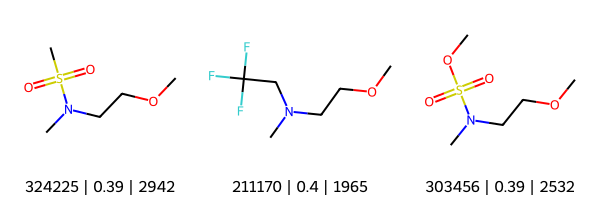

In [44]:
PandasTools.AddMoleculeColumnToFrame(alt_fin, smilesCol='solv_comb_sm')
PandasTools.FrameToGridImage(alt_fin, legendsCol='label', molsPerRow=3)


In [31]:
top_1000_fin.loc[top_1000_fin['solv_comb_sm'] == smi_1]
top_1000_fin.loc[top_1000_fin['solv_comb_sm'] == smi_1_c]
top_1000_fin.loc[top_1000_fin['solv_comb_sm'] == smi_2]
top_1000_fin.loc[top_1000_fin['solv_comb_sm'] == smi_2_c]
top_1000_fin.loc[top_1000_fin['solv_comb_sm'] == smi_3]
top_1000_fin.loc[top_1000_fin['solv_comb_sm'] == smi_3_c]

,index_0,solv_comb_sm,rank,mean_pred,TSNE_0,TSNE_1


In [33]:
top_1000_fin['rank'].max()

1869.0

**ignore below...**

In [ ]:
## obtained after entering the smiles list manually into eMolecules online search & saving the results as csv
df_sugg_500_emol = pd.read_csv('sugg_emolecules_1_test2.csv')
df_sugg_500_emol['solv_comb_sm'] = df_sugg_500_emol.apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x['smiles'])), axis=1)
df_sugg_500_emol

In [163]:
list_suggest_emol_bool = df_comb_tsne['solv_comb_sm'].isin(df_sugg_500_emol['solv_comb_sm'])
sugg_ind_emol = [i for i in range(len(list_suggest_emol_bool)) if list_suggest_emol_bool[i] == True]
# sugg_ind_emol
df_tsne_2 = df_comb_tsne.copy()
df_tsne_2['database'] = 'unlabel'
df_tsne_2.loc[label_ind, 'database'] = 'label'
df_tsne_2.loc[sugg_ind_emol, 'database'] = 'suggest_emol'

In [164]:
df_comb_tsne['database'].unique()
df_tsne_2['database'].unique()

array(['unlabel', 'suggest_emol', 'label'], dtype=object)

In [ ]:
fig_scatter = px.scatter(df_tsne_2,
                         x="TSNE_0",
                         y="TSNE_1",
                         color='database',
                         hover_data=['solv_comb_sm'],
                         labels={'solv_comb_sm'},
                         width=1000,
                         height=800)
fig_scatter.update_traces(marker=dict(size=7))
fig_scatter.show()

In [174]:
len(df['solv_comb_sm'].unique())

25

In [ ]:
from electropy import molecules
# molecules.check_similarity('FC(F)C1(F)CCCS1')
ref_mol = [Chem.MolFromSmiles(sm) for sm in df['solv_comb_sm'].unique()]
ref_fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2) for mol in ref_mol]
def check_similarity(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mol_fps = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    similarity = [DataStructs.FingerprintSimilarity(mol_fps, ref) for ref in ref_fps]
    max_sim = max(similarity)
    # max_sim = 1.0
    ind = similarity.index(max_sim)
    return max_sim, ind

for i in range(len(df_sugg_500_emol)):
    max_sim, ind = check_similarity(df_sugg_500_emol['smiles'][i])
    df_sugg_500_emol.loc[i, 'max_sim'] = max_sim
    df_sugg_500_emol.loc[i, 'label_solv_sm'] = df['solv_comb_sm'][ind]
    # print(max_sim, ind)
    # print(df['solv_comb_sm'][ind])

df_sugg_500_emol.drop(['ind'], axis=1, inplace=True)
df_sugg_500_emol

In [ ]:
df_sugg_emol_tsne = df_tsne_2.loc[df_tsne_2['database'] == 'suggest_emol'][['solv_comb_sm', 'TSNE_0', 'TSNE_1']]
PandasTools.AddMoleculeColumnToFrame(df_sugg_emol_tsne, smilesCol='solv_comb_sm')
PandasTools.FrameToGridImage(df_sugg_emol_tsne, legendsCol="solv_comb_sm", molsPerRow=5)

In [ ]:
df_sugg_emol_tsne

In [ ]:
tt = df_unlabel_.copy()
tt.sort_values(by=['norm_capacity_3_pred'], ascending=False, inplace=True)
tt